<a href="https://colab.research.google.com/github/obeabi/SDSDecember2020Challenge/blob/main/model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Written by Abiola Obembe
# SDS October Challenge #4 - Hostel Price Prediction
2021-02-12

This month’s challenge is to build a data driven model determine a fair price for new hostels based on previous hostel data. Specifically, my objective is to predict the price of each hostel based on the data provided using numerical columns only

### Step 1: Data Import




In [67]:
# Install libraries not inbuilt
!pip install category_encoders
! pip install catboost

In [68]:
# Import required libraries
import pandas as pd
import numpy as np
import statsmodels
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import  zscore
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category = DeprecationWarning)

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('Libraries installed successfully!')

np.random.seed(0)

Libraries installed successfully!


In [69]:
# Importing the training dataset

df_train = pd.read_csv('public_listings.csv', engine= 'python', encoding= 'latin1')

df_train.head(2)

,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
0,Quiet and safe one bedroom in Upper Manhattan,Cozy yet spacious one bedroom with lots of lig...,Safe and family-oriented with well lit streets...,https://a0.muscache.com/pictures/0f3679a5-e907...,Mark,12/3/18,"New York, New York, United States",My name is Mark and I own a small Internet mar...,within an hour,100%,77%,t,https://a0.muscache.com/im/pictures/user/9abd1...,https://a0.muscache.com/im/pictures/user/9abd1...,Washington Heights,1.0,1.0,"['email', 'phone', 'offline_government_id', 'g...",t,t,"New York, United States",Washington Heights,Manhattan,40.85502,-73.92763000000002,Entire apartment,Entire home/apt,2.0,1 bath,1.0,1.0,"[""Hot water"", ""Smoke alarm"", ""Laptop-friendly ...",6.0,30,6.0,6.0,1125.0,1125.0,6.0,1125.0,t,19.0,49,79,354.0,10/9/20,23.0,6.0,1.0,12/9/18,9/24/20,95.0,10.0,8.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,1.03,110
1,Big Sunny Room 10secs from L train,My large two bedroom apt is a great place to s...,Williamsburg is such a cool place to live. The...,https://a0.muscache.com/pictures/60023372/29c3...,Lauren,1/23/12,"New York, New York, United States",Iv'e seen over 300 films. I am an actor living...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1641589/profi...,https://a0.muscache.com/im/users/1641589/profi...,Williamsburg,1,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Brooklyn, New York, United States",Williamsburg,Brooklyn,40.71172,-73.93973,Private room in apartment,Private room,2.0,1 bath,1.0,1.0,"[""Shampoo"", ""Heating"", ""Essentials"", ""Kitchen""...",2.0,1125,2.0,2.0,1125.0,1125.0,2,1125.0,t,0.0,0,0,0.0,10/12/20,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1.0,0.0,1.0,0.0,NaN,60


In [70]:
 #Importing the test dataset

df_test = pd.read_csv('pred_listings.csv', engine= 'python', encoding= 'latin1')

df_test.head(2)

,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,Heart of Park Slope,"This two room private suite, suitable for a co...",Park Slope is a beautiful neighborhood of tree...,https://a0.muscache.com/pictures/c6fda99b-1b21...,Nancy,5/2/18,"Brooklyn, New York, United States",I am an artist and I run a small gallery in my...,within a few hours,100%,100%,t,https://a0.muscache.com/im/pictures/user/9c243...,https://a0.muscache.com/im/pictures/user/9c243...,Park Slope,1.0,1.0,"['email', 'phone']",t,f,"Brooklyn, New York, United States",Park Slope,Brooklyn,40.67384,-73.97743,Private room in condominium,Private room,2.0,1 private bath,1.0,1.0,"[""Private entrance"", ""Hot water"", ""Extra pillo...",2.0,21,2.0,2.0,1125.0,1125.0,2.0,1125.0,t,28.0,58,88,177.0,10/8/20,58.0,16.0,0.0,6/6/18,7/30/20,99.0,10.0,10.0,10.0,10.0,10.0,10.0,t,1.0,0.0,1.0,0.0,2.03
1,"Gramercy Park restful, cozy, sun-filled home","In the charming Gramercy Park neighborhood, ou...",The Gramercy Park area is a quiet residential ...,https://a0.muscache.com/pictures/6cc018db-208a...,Javier,3/3/15,"New York, New York, United States",I am passionate about history and culture born...,within an hour,100%,91%,t,https://a0.muscache.com/im/pictures/user/a8830...,https://a0.muscache.com/im/pictures/user/a8830...,Gramercy Park,5,5.0,"['email', 'phone', 'reviews', 'jumio', 'selfie...",t,t,"New York, United States",Gramercy,Manhattan,40.73618,-73.9833,Entire apartment,Entire home/apt,2.0,1 bath,1.0,2.0,"[""Long term stays allowed"", ""Carbon monoxide a...",2.0,15,2.0,3.0,1125.0,1125.0,2,1125.0,t,18.0,48,77,77.0,10/12/20,76.0,17.0,0.0,9/20/17,3/8/20,97,10.0,10.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,2.04


In [71]:
# priniting the details about the train dataset

print("\nEDA on Training Set\n")
print("#"*30)

print("\n\nNumber of Features/Columns : ", len(df_train.columns))
print("\nNumber of Rows : ",df_train.shape[0])


print("\n Contains NaN/Empty cells : ", df_train.isnull().values.any())


missing_values = df_train.isnull().sum().sum()
print("\n Total missing values in train dataframe is: \n", str(missing_values))

total_data = np.product(df_train.shape)

print("\n Perecentage of missing values in train dataframe is: \n", str(100*(missing_values/total_data))+'%')


EDA on Training Set

##############################


Number of Features/Columns :  65

Number of Rows :  35734

 Contains NaN/Empty cells :  True

 Total missing values in train dataframe is: 
 192264

 Perecentage of missing values in train dataframe is: 
 8.277572318541704%


In [72]:
# Check for missing values in train set columns
print("\n Total empty cells by column :\n", df_train.isnull().sum(), "\n\n")



 Total empty cells by column :
 name                                               13
description                                      1018
neighborhood_overview                           13151
picture_url                                         1
host_name                                          14
                                                ...  
calculated_host_listings_count_entire_homes         3
calculated_host_listings_count_private_rooms        3
calculated_host_listings_count_shared_rooms         3
reviews_per_month                                8402
price                                               2
Length: 65, dtype: int64 




### Step 2: Data Preprocessing/Cleaning

In [73]:
# Drop missing values in price column
print("Original Length of Training Set : ", len(df_train))
df_train.dropna(subset=['price'], axis = 0, inplace= True)
print("Length of Training Set after dropping NaN in target column: ", len(df_train))

Original Length of Training Set :  35734
Length of Training Set after dropping NaN in target column:  35732


In [74]:
# priniting the details about the new train dataset

print("\n Contains NaN/Empty cells : ", df_train.isnull().values.any())


print("\n Perecentage of missing values in train dataframe is: \n", str(100*(df_train.isnull().sum().sum()/(df_train.shape[0]* df_train.shape[1])))+'%')


 Contains NaN/Empty cells :  True

 Perecentage of missing values in train dataframe is: 
 8.273127298090916%


In [75]:
# Print dataframe info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35732 entries, 0 to 35733
Data columns (total 65 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          35719 non-null  object 
 1   description                                   34714 non-null  object 
 2   neighborhood_overview                         22581 non-null  object 
 3   picture_url                                   35731 non-null  object 
 4   host_name                                     35718 non-null  object 
 5   host_since                                    35718 non-null  object 
 6   host_location                                 35623 non-null  object 
 7   host_about                                    21383 non-null  object 
 8   host_response_time                            17297 non-null  object 
 9   host_response_rate                            17297 non-null 

In [76]:
# priniting the details about the test dataset

print("#"*30)
print("\nEDA on Test Set\n")
print("#"*30)

print("\n\nNumber of Features/Columns : ", len(df_test.columns))
print("\nNumber of Rows : ",df_test.shape[0])


print("\n Contains NaN/Empty cells : ", df_test.isnull().values.any())


missing_values = df_test.isnull().sum().sum()
print("\n Total missing values in train dataframe is: \n", str(missing_values))

total_data = np.product(df_test.shape)

print("\n Perecentage of missing values in train dataframe is: \n", str(100*(missing_values/total_data))+'%')


##############################

EDA on Test Set

##############################


Number of Features/Columns :  64

Number of Rows :  8934

 Contains NaN/Empty cells :  True

 Total missing values in train dataframe is: 
 48176

 Perecentage of missing values in train dataframe is: 
 8.425677188269534%


In [77]:
# Convert host since and calender last scraped to date-time format and adding new columns to the dataframe
date_cols = ['host_since','calendar_last_scraped']

df_train[date_cols].isnull().sum()


host_since               14
calendar_last_scraped     0
dtype: int64

In [78]:
# Drop columns with missing values as we can't impute this field
df_train.dropna(axis = 0, subset= date_cols, inplace= True)
df_test.dropna(axis = 0, subset= date_cols, inplace= True)

print("Missing values after dropping is :", df_train[date_cols].isnull().sum().sum())

Missing values after dropping is : 0


In [79]:
# Create dataframe with only date columns to work with
train_date =df_train[date_cols]
test_date = df_test[date_cols]

train_date.head()

,host_since,calendar_last_scraped
0,12/3/18,10/9/20
1,1/23/12,10/12/20
2,3/5/16,10/9/20
3,1/30/16,10/6/20
4,2/2/14,10/5/20


In [80]:
# Check for missing values
test_date.isnull().sum()


host_since               0
calendar_last_scraped    0
dtype: int64

In [82]:
# Find problematic row in https format in host_since abd calender_last scraped in train set
result1 = train_date.host_since.str.match(pat = '(https:).') 
print(result1[result1 == True])

result2 = train_date.calendar_last_scraped.str.match(pat = '(https:).') 
print(result2[result2 == True])

17613    True
Name: host_since, dtype: bool
Series([], Name: calendar_last_scraped, dtype: bool)


In [83]:
# Find problematic row in https format in host_since abd calender_last scraped in train set
result1 = test_date.host_since.str.match(pat = '(https:).') 
print(result1[result1 == True])

result2 = test_date.calendar_last_scraped.str.match(pat = '(https:).') 
print(result2[result2 == True])

6874    True
Name: host_since, dtype: bool
Series([], Name: calendar_last_scraped, dtype: bool)


In [84]:
# Let's rows with https in values
train_date =train_date.drop(17613)

test_date = test_date.drop(6874)


In [85]:
# Let' also drop the same values in our original dataset
df_train = df_train.drop(17613)
df_test = df_test.drop(6874)

df_train.reset_index(drop= True)
df_test.reset_index(drop= True)

,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,Heart of Park Slope,"This two room private suite, suitable for a co...",Park Slope is a beautiful neighborhood of tree...,https://a0.muscache.com/pictures/c6fda99b-1b21...,Nancy,5/2/18,"Brooklyn, New York, United States",I am an artist and I run a small gallery in my...,within a few hours,100%,100%,t,https://a0.muscache.com/im/pictures/user/9c243...,https://a0.muscache.com/im/pictures/user/9c243...,Park Slope,1.0,1.0,"['email', 'phone']",t,f,"Brooklyn, New York, United States",Park Slope,Brooklyn,40.67384,-73.97743,Private room in condominium,Private room,2.0,1 private bath,1.0,1.0,"[""Private entrance"", ""Hot water"", ""Extra pillo...",2.0,21,2.0,2.0,1125.0,1125.0,2.0,1125.0,t,28.0,58,88,177.0,10/8/20,58.0,16.0,0.0,6/6/18,7/30/20,99.0,10.0,10.0,10.0,10.0,10.0,10.0,t,1.0,0.0,1.0,0.0,2.03
1,"Gramercy Park restful, cozy, sun-filled home","In the charming Gramercy Park neighborhood, ou...",The Gramercy Park area is a quiet residential ...,https://a0.muscache.com/pictures/6cc018db-208a...,Javier,3/3/15,"New York, New York, United States",I am passionate about history and culture born...,within an hour,100%,91%,t,https://a0.muscache.com/im/pictures/user/a8830...,https://a0.muscache.com/im/pictures/user/a8830...,Gramercy Park,5,5.0,"['email', 'phone', 'reviews', 'jumio', 'selfie...",t,t,"New York, United States",Gramercy,Manhattan,40.73618,-73.9833,Entire apartment,Entire home/apt,2.0,1 bath,1.0,2.0,"[""Long term stays allowed"", ""Carbon monoxide a...",2.0,15,2.0,3.0,1125.0,1125.0,2,1125.0,t,18.0,48,77,77.0,10/12/20,76.0,17.0,0.0,9/20/17,3/8/20,97,10.0,10.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,2.04
2,Serene art-filled apartment near Prospect Park,Serene Brooklyn apartment near Prospect Park. ...,NaN,https://a0.muscache.com/pictures/550be13c-4fbb...,Dara,6/19/12,"New York, New York, United States",Documentary filmmaker and writer living in Bro...,NaN,NaN,50%,f,https://a0.muscache.com/im/users/2681144/profi...,https://a0.muscache.com/im/users/2681144/profi...,Flatbush,1.0,1.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,NaN,Flatbush,Brooklyn,40.65120,-73.95908,Entire apartment,Entire home/apt,3.0,1 bath,1.0,1.0,"[""Carbon monoxide alarm"", ""Washer"", ""Shower ge...",10.0,90,10.0,10.0,90.0,90.0,10.0,90.0,t,0.0,0,0,0.0,10/10/20,21.0,2.0,0.0,12/15/18,12/18/19,96.0,10.0,9.0,9.0,10.0,9.0,9.0,f,1.0,1.0,0.0,0.0,0.95
3,Sunny bdr w stunning view in prime Williamsbur...,Beautiful new apartment in prime Williamsburg....,The place is super close to all the best bars ...,https://a0.muscache.com/pictures/d578e2bb-6bfd...,Cristina,9/16/13,"New York, New York, United States",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/6dca6...,https://a0.muscache.com/im/pictures/user/6dca6...,NaN,1.0,1.0,"['email', 'phone', 'reviews', 'ju

In [86]:
# Test is string still present
result1 = test_date.host_since.str.match(pat = '(https:).') 
print(result1[result1 == True])

Series([], Name: host_since, dtype: bool)


In [87]:
# Let's start with host_since column
x = pd.to_datetime(train_date.host_since, format='%m/%d/%y').dt.day
x

0         3
1        23
2         5
3        30
4         2
         ..
35729     9
35730     7
35731    19
35732    25
35733     4
Name: host_since, Length: 35717, dtype: int64

In [88]:
# Create new columns for host_since and calender_last scraped in train set
# Host_since
df_train['host_since_Day'] = pd.to_datetime(df_train.host_since, format='%m/%d/%y').dt.day
df_train['host_since_Month'] = pd.to_datetime(df_train.host_since, format='%m/%d/%y').dt.month
df_train['host_since_Year'] = pd.to_datetime(df_train.host_since, format='%m/%d/%y').dt.year 

# calender last scraped
df_train['calendar_last_scraped_Day'] = pd.to_datetime(df_train.calendar_last_scraped, format='%m/%d/%y').dt.day
df_train['calendar_last_scraped_Month'] = pd.to_datetime(df_train.calendar_last_scraped, format='%m/%d/%y').dt.month
df_train['calendar_last_scraped_Year'] = pd.to_datetime(df_train.calendar_last_scraped, format='%m/%d/%y').dt.year

df_train.head()

,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price,host_since_Day,host_since_Month,host_since_Year,calendar_last_scraped_Day,calendar_last_scraped_Month,calendar_last_scraped_Year
0,Quiet and safe one bedroom in Upper Manhattan,Cozy yet spacious one bedroom with lots of lig...,Safe and family-oriented with well lit streets...,https://a0.muscache.com/pictures/0f3679a5-e907...,Mark,12/3/18,"New York, New York, United States",My name is Mark and I own a small Internet mar...,within an hour,100%,77%,t,https://a0.muscache.com/im/pictures/user/9abd1...,https://a0.muscache.com/im/pictures/user/9abd1...,Washington Heights,1.0,1.0,"['email', 'phone', 'offline_government_id', 'g...",t,t,"New York, United States",Washington Heights,Manhattan,40.85502,-73.92763000000002,Entire apartment,Entire home/apt,2.0,1 bath,1.0,1.0,"[""Hot water"", ""Smoke alarm"", ""Laptop-friendly ...",6.0,30,6.0,6.0,1125.0,1125.0,6.0,1125.0,t,19.0,49,79,354.0,10/9/20,23.0,6.0,1.0,12/9/18,9/24/20,95.0,10.0,8.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,1.03,110,3,12,2018,9,10,2020
1,Big Sunny Room 10secs from L train,My large two bedroom apt is a great place to s...,Williamsburg is such a cool place to live. The...,https://a0.muscache.com/pictures/60023372/29c3...,Lauren,1/23/12,"New York, New York, United States",Iv'e seen over 300 films. I am an actor living...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1641589/profi...,https://a0.muscache.com/im/users/1641589/profi...,Williamsburg,1,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Brooklyn, New York, United States",Williamsburg,Brooklyn,40.71172,-73.93973,Private room in apartment,Private room,2.0,1 bath,1.0,1.0,"[""Shampoo"", ""Heating"", ""Essentials"", ""Kitchen""...",2.0,1125,2.0,2.0,1125.0,1125.0,2,1125.0,t,0.0,0,0,0.0,10/12/20,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1.0,0.0,1.0,0.0,NaN,60,23,1,2012,12,10,2020
2,Modern New Condo 20 minutes to upper west side,Modern homey condo - (keyed)private bedroom & ...,Safe neighborhood. Security cameras outside th...,https://a0.muscache.com/pictures/a0073afa-b976...,Shanthi,3/5/16,"New York, New York, United States",NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/3a42b...,https://a0.muscache.com/im/pictures/user/3a42b...,Kingsbridge Heights,2,2.0,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Bronx, New York, United States",Kingsbridge,Bronx,40.87870,-73.90098,Private room in condominium,Private room,1.0,1 private bath,1.0,1.0,"[""Wifi"", ""Dryer"", ""Hangers"", ""Hot water"", ""Loc...",30.0,120,30.0,30.0,120.0,120.0,30,120.0,t,28.0,58,88,178.0,10/9/20,9.0,1.0,0.0,5/11/18,12/17/19,89,9.0,7.0,10.0,10.0,9.0,9.0,f,2.0,0.0,2.0,0.0,0.31,39,5,3,2016,9,10,2020
3,Lower East Side Apartment,The apartment is located in the heart of the L...,NaN,https://a0.muscache.com/pi

In [89]:
# Create new columns for host_since and calender_last scraped in test set
# Host_since
df_test['host_since_Day'] = pd.to_datetime(df_test.host_since, format='%m/%d/%y').dt.day
df_test['host_since_Month'] = pd.to_datetime(df_test.host_since, format='%m/%d/%y').dt.month
df_test['host_since_Year'] = pd.to_datetime(df_test.host_since, format='%m/%d/%y').dt.year 

# calender last scraped
df_test['calendar_last_scraped_Day'] = pd.to_datetime(df_test.calendar_last_scraped, format='%m/%d/%y').dt.day
df_test['calendar_last_scraped_Month'] = pd.to_datetime(df_test.calendar_last_scraped, format='%m/%d/%y').dt.month
df_test['calendar_last_scraped_Year'] = pd.to_datetime(df_test.calendar_last_scraped, format='%m/%d/%y').dt.year

df_test.head()

,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_Day,host_since_Month,host_since_Year,calendar_last_scraped_Day,calendar_last_scraped_Month,calendar_last_scraped_Year
0,Heart of Park Slope,"This two room private suite, suitable for a co...",Park Slope is a beautiful neighborhood of tree...,https://a0.muscache.com/pictures/c6fda99b-1b21...,Nancy,5/2/18,"Brooklyn, New York, United States",I am an artist and I run a small gallery in my...,within a few hours,100%,100%,t,https://a0.muscache.com/im/pictures/user/9c243...,https://a0.muscache.com/im/pictures/user/9c243...,Park Slope,1.0,1.0,"['email', 'phone']",t,f,"Brooklyn, New York, United States",Park Slope,Brooklyn,40.67384,-73.97743,Private room in condominium,Private room,2.0,1 private bath,1.0,1.0,"[""Private entrance"", ""Hot water"", ""Extra pillo...",2.0,21,2.0,2.0,1125.0,1125.0,2.0,1125.0,t,28.0,58,88,177.0,10/8/20,58.0,16.0,0.0,6/6/18,7/30/20,99.0,10.0,10.0,10.0,10.0,10.0,10.0,t,1.0,0.0,1.0,0.0,2.03,2,5,2018,8,10,2020
1,"Gramercy Park restful, cozy, sun-filled home","In the charming Gramercy Park neighborhood, ou...",The Gramercy Park area is a quiet residential ...,https://a0.muscache.com/pictures/6cc018db-208a...,Javier,3/3/15,"New York, New York, United States",I am passionate about history and culture born...,within an hour,100%,91%,t,https://a0.muscache.com/im/pictures/user/a8830...,https://a0.muscache.com/im/pictures/user/a8830...,Gramercy Park,5,5.0,"['email', 'phone', 'reviews', 'jumio', 'selfie...",t,t,"New York, United States",Gramercy,Manhattan,40.73618,-73.9833,Entire apartment,Entire home/apt,2.0,1 bath,1.0,2.0,"[""Long term stays allowed"", ""Carbon monoxide a...",2.0,15,2.0,3.0,1125.0,1125.0,2,1125.0,t,18.0,48,77,77.0,10/12/20,76.0,17.0,0.0,9/20/17,3/8/20,97,10.0,10.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,2.04,3,3,2015,12,10,2020
2,Serene art-filled apartment near Prospect Park,Serene Brooklyn apartment near Prospect Park. ...,NaN,https://a0.muscache.com/pictures/550be13c-4fbb...,Dara,6/19/12,"New York, New York, United States",Documentary filmmaker and writer living in Bro...,NaN,NaN,50%,f,https://a0.muscache.com/im/users/2681144/profi...,https://a0.muscache.com/im/users/2681144/profi...,Flatbush,1.0,1.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,NaN,Flatbush,Brooklyn,40.65120,-73.95908,Entire apartment,Entire home/apt,3.0,1 bath,1.0,1.0,"[""Carbon monoxide alarm"", ""Washer"", ""Shower ge...",10.0,90,10.0,10.0,90.0,90.0,10.0,90.0,t,0.0,0,0,0.0,10/10/20,21.0,2.0,0.0,12/15/18,12/18/19,96.0,10.0,9.0,9.0,10.0,9.0,9.0,f,1.0,1.0,0.0,0.0,0.95,19,6,2012,10,10,2020
3,Sunny bdr w stunning view in prime Williamsbur...,Beautiful new apartment in prime Williamsburg....,The place is super close to all the best bars ...,https://a0.muscache.com/pictures/d578e2bb-6bfd...,Cristina,9/16/13,"New York, 

In [91]:
# Drop original host_since and calender-last scraped columns

df_train.drop( date_cols, axis = 1, inplace= True)

df_test.drop(date_cols, axis =1 , inplace=True)

df_train.head()

,name,description,neighborhood_overview,picture_url,host_name,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price,host_since_Day,host_since_Month,host_since_Year,calendar_last_scraped_Day,calendar_last_scraped_Month,calendar_last_scraped_Year
0,Quiet and safe one bedroom in Upper Manhattan,Cozy yet spacious one bedroom with lots of lig...,Safe and family-oriented with well lit streets...,https://a0.muscache.com/pictures/0f3679a5-e907...,Mark,"New York, New York, United States",My name is Mark and I own a small Internet mar...,within an hour,100%,77%,t,https://a0.muscache.com/im/pictures/user/9abd1...,https://a0.muscache.com/im/pictures/user/9abd1...,Washington Heights,1.0,1.0,"['email', 'phone', 'offline_government_id', 'g...",t,t,"New York, United States",Washington Heights,Manhattan,40.85502,-73.92763000000002,Entire apartment,Entire home/apt,2.0,1 bath,1.0,1.0,"[""Hot water"", ""Smoke alarm"", ""Laptop-friendly ...",6.0,30,6.0,6.0,1125.0,1125.0,6.0,1125.0,t,19.0,49,79,354.0,23.0,6.0,1.0,12/9/18,9/24/20,95.0,10.0,8.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,1.03,110,3,12,2018,9,10,2020
1,Big Sunny Room 10secs from L train,My large two bedroom apt is a great place to s...,Williamsburg is such a cool place to live. The...,https://a0.muscache.com/pictures/60023372/29c3...,Lauren,"New York, New York, United States",Iv'e seen over 300 films. I am an actor living...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1641589/profi...,https://a0.muscache.com/im/users/1641589/profi...,Williamsburg,1,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Brooklyn, New York, United States",Williamsburg,Brooklyn,40.71172,-73.93973,Private room in apartment,Private room,2.0,1 bath,1.0,1.0,"[""Shampoo"", ""Heating"", ""Essentials"", ""Kitchen""...",2.0,1125,2.0,2.0,1125.0,1125.0,2,1125.0,t,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1.0,0.0,1.0,0.0,NaN,60,23,1,2012,12,10,2020
2,Modern New Condo 20 minutes to upper west side,Modern homey condo - (keyed)private bedroom & ...,Safe neighborhood. Security cameras outside th...,https://a0.muscache.com/pictures/a0073afa-b976...,Shanthi,"New York, New York, United States",NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/3a42b...,https://a0.muscache.com/im/pictures/user/3a42b...,Kingsbridge Heights,2,2.0,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Bronx, New York, United States",Kingsbridge,Bronx,40.87870,-73.90098,Private room in condominium,Private room,1.0,1 private bath,1.0,1.0,"[""Wifi"", ""Dryer"", ""Hangers"", ""Hot water"", ""Loc...",30.0,120,30.0,30.0,120.0,120.0,30,120.0,t,28.0,58,88,178.0,9.0,1.0,0.0,5/11/18,12/17/19,89,9.0,7.0,10.0,10.0,9.0,9.0,f,2.0,0.0,2.0,0.0,0.31,39,5,3,2016,9,10,2020
3,Lower East Side Apartment,The apartment is located in the heart of the L...,NaN,https://a0.muscache.com/pictures/0a84b409-935d...,Sabina,"New York, New York, United States",NaN,NaN,NaN,Na

In [92]:
# Let's see test set too
df_test.head()

,name,description,neighborhood_overview,picture_url,host_name,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_Day,host_since_Month,host_since_Year,calendar_last_scraped_Day,calendar_last_scraped_Month,calendar_last_scraped_Year
0,Heart of Park Slope,"This two room private suite, suitable for a co...",Park Slope is a beautiful neighborhood of tree...,https://a0.muscache.com/pictures/c6fda99b-1b21...,Nancy,"Brooklyn, New York, United States",I am an artist and I run a small gallery in my...,within a few hours,100%,100%,t,https://a0.muscache.com/im/pictures/user/9c243...,https://a0.muscache.com/im/pictures/user/9c243...,Park Slope,1.0,1.0,"['email', 'phone']",t,f,"Brooklyn, New York, United States",Park Slope,Brooklyn,40.67384,-73.97743,Private room in condominium,Private room,2.0,1 private bath,1.0,1.0,"[""Private entrance"", ""Hot water"", ""Extra pillo...",2.0,21,2.0,2.0,1125.0,1125.0,2.0,1125.0,t,28.0,58,88,177.0,58.0,16.0,0.0,6/6/18,7/30/20,99.0,10.0,10.0,10.0,10.0,10.0,10.0,t,1.0,0.0,1.0,0.0,2.03,2,5,2018,8,10,2020
1,"Gramercy Park restful, cozy, sun-filled home","In the charming Gramercy Park neighborhood, ou...",The Gramercy Park area is a quiet residential ...,https://a0.muscache.com/pictures/6cc018db-208a...,Javier,"New York, New York, United States",I am passionate about history and culture born...,within an hour,100%,91%,t,https://a0.muscache.com/im/pictures/user/a8830...,https://a0.muscache.com/im/pictures/user/a8830...,Gramercy Park,5,5.0,"['email', 'phone', 'reviews', 'jumio', 'selfie...",t,t,"New York, United States",Gramercy,Manhattan,40.73618,-73.9833,Entire apartment,Entire home/apt,2.0,1 bath,1.0,2.0,"[""Long term stays allowed"", ""Carbon monoxide a...",2.0,15,2.0,3.0,1125.0,1125.0,2,1125.0,t,18.0,48,77,77.0,76.0,17.0,0.0,9/20/17,3/8/20,97,10.0,10.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,2.04,3,3,2015,12,10,2020
2,Serene art-filled apartment near Prospect Park,Serene Brooklyn apartment near Prospect Park. ...,NaN,https://a0.muscache.com/pictures/550be13c-4fbb...,Dara,"New York, New York, United States",Documentary filmmaker and writer living in Bro...,NaN,NaN,50%,f,https://a0.muscache.com/im/users/2681144/profi...,https://a0.muscache.com/im/users/2681144/profi...,Flatbush,1.0,1.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,NaN,Flatbush,Brooklyn,40.65120,-73.95908,Entire apartment,Entire home/apt,3.0,1 bath,1.0,1.0,"[""Carbon monoxide alarm"", ""Washer"", ""Shower ge...",10.0,90,10.0,10.0,90.0,90.0,10.0,90.0,t,0.0,0,0,0.0,21.0,2.0,0.0,12/15/18,12/18/19,96.0,10.0,9.0,9.0,10.0,9.0,9.0,f,1.0,1.0,0.0,0.0,0.95,19,6,2012,10,10,2020
3,Sunny bdr w stunning view in prime Williamsbur...,Beautiful new apartment in prime Williamsburg....,The place is super close to all the best bars ...,https://a0.muscache.com/pictures/d578e2bb-6bfd...,Cristina,"New York, New York, United States",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/6dca6

In [103]:
# Let's see the data types
df_train.dtypes

name                           object
description                    object
neighborhood_overview          object
picture_url                    object
host_name                      object
                                ...  
host_since_Month                int64
host_since_Year                 int64
calendar_last_scraped_Day       int64
calendar_last_scraped_Month     int64
calendar_last_scraped_Year      int64
Length: 69, dtype: object

In [ ]:
# Convert object columns to numerical columns in train and test dataframe
df_train[['price', 'host_response_rate','host_acceptance_rate','review_scores_rating']]= df_train[['price', 'host_response_rate','host_acceptance_rate','review_scores_rating']].replace({',':'', ' ': '', '%':''} , regex = True)

df_test[[ 'host_response_rate','host_acceptance_rate','review_scores_rating']]= df_test[['host_response_rate','host_acceptance_rate','review_scores_rating']].replace({',':'', ' ': '', '%':''} , regex = True)

df_train['price']= df_train.price.astype(float)
df_train['host_response_rate']= df_train.host_response_rate.astype(float)


# test set
df_test['host_response_rate']= df_test.host_response_rate.astype(float)


df_train.head(2)


,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
0,Quiet and safe one bedroom in Upper Manhattan,Cozy yet spacious one bedroom with lots of lig...,Safe and family-oriented with well lit streets...,https://a0.muscache.com/pictures/0f3679a5-e907...,Mark,12/3/18,"New York, New York, United States",My name is Mark and I own a small Internet mar...,within an hour,100.0,77,t,https://a0.muscache.com/im/pictures/user/9abd1...,https://a0.muscache.com/im/pictures/user/9abd1...,Washington Heights,1.0,1.0,"['email', 'phone', 'offline_government_id', 'g...",t,t,"New York, United States",Washington Heights,Manhattan,40.85502,-73.92763000000002,Entire apartment,Entire home/apt,2.0,1 bath,1.0,1.0,"[""Hot water"", ""Smoke alarm"", ""Laptop-friendly ...",6.0,30,6.0,6.0,1125.0,1125.0,6.0,1125.0,t,19.0,49,79,354.0,10/9/20,23.0,6.0,1.0,12/9/18,9/24/20,95.0,10.0,8.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,1.03,110.0
1,Big Sunny Room 10secs from L train,My large two bedroom apt is a great place to s...,Williamsburg is such a cool place to live. The...,https://a0.muscache.com/pictures/60023372/29c3...,Lauren,1/23/12,"New York, New York, United States",Iv'e seen over 300 films. I am an actor living...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1641589/profi...,https://a0.muscache.com/im/users/1641589/profi...,Williamsburg,1,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Brooklyn, New York, United States",Williamsburg,Brooklyn,40.71172,-73.93973,Private room in apartment,Private room,2.0,1 bath,1.0,1.0,"[""Shampoo"", ""Heating"", ""Essentials"", ""Kitchen""...",2.0,1125,2.0,2.0,1125.0,1125.0,2,1125.0,t,0.0,0,0,0.0,10/12/20,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1.0,0.0,1.0,0.0,NaN,60.0


In [ ]:
# Find error line in host acceptance-rate column in train set
df_train.host_acceptance_rate.value_counts()

100                                                7270
0                                                  1195
99                                                  870
50                                                  794
97                                                  759
                                                   ... 
8                                                     4
12                                                    3
5                                                     2
15                                                    2
['email''phone''reviews''jumio''government_id']       1
Name: host_acceptance_rate, Length: 97, dtype: int64

In [ ]:
# Find error line in host acceptance-rate column in test set
df_test.host_acceptance_rate.value_counts()

100                                                     1775
0                                                        309
99                                                       244
97                                                       229
98                                                       204
                                                        ... 
7                                                          1
['email''phone''facebook''reviews''kba''work_email']       1
6                                                          1
16                                                         1
41                                                         1
Name: host_acceptance_rate, Length: 94, dtype: int64

In [ ]:
# drop problematic row in host_acceptance_rate
to_drop_train =  "['email''phone''reviews''jumio''government_id']"
to_drop_test = "['email''phone''facebook''reviews''kba''work_email']"

index_train= df_train[ df_train['host_acceptance_rate'] == to_drop_train].index
index_test= df_test[ df_test['host_acceptance_rate'] == to_drop_test].index

# drop indexes
df_train.drop(index_train, inplace = True) 
df_test.drop(index_test, inplace = True) 

# Change data type to float
df_train['host_acceptance_rate']= df_train.host_acceptance_rate.astype(float)
df_test['host_acceptance_rate']= df_test.host_acceptance_rate.astype(float)

In [ ]:
df_train['review_scores_rating']= df_train.review_scores_rating.astype(float)
df_test['review_scores_rating']= df_test.review_scores_rating.astype(float)

# Address lonitude column
df_train['longitude']= df_train.longitude.astype(float)
df_test['longitude']= df_test.longitude.astype(float)

df_train.head(2)

,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
0,Quiet and safe one bedroom in Upper Manhattan,Cozy yet spacious one bedroom with lots of lig...,Safe and family-oriented with well lit streets...,https://a0.muscache.com/pictures/0f3679a5-e907...,Mark,12/3/18,"New York, New York, United States",My name is Mark and I own a small Internet mar...,within an hour,100.0,77.0,t,https://a0.muscache.com/im/pictures/user/9abd1...,https://a0.muscache.com/im/pictures/user/9abd1...,Washington Heights,1.0,1.0,"['email', 'phone', 'offline_government_id', 'g...",t,t,"New York, United States",Washington Heights,Manhattan,40.85502,-73.92763,Entire apartment,Entire home/apt,2.0,1 bath,1.0,1.0,"[""Hot water"", ""Smoke alarm"", ""Laptop-friendly ...",6.0,30,6.0,6.0,1125.0,1125.0,6.0,1125.0,t,19.0,49,79,354.0,10/9/20,23.0,6.0,1.0,12/9/18,9/24/20,95.0,10.0,8.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,1.03,110.0
1,Big Sunny Room 10secs from L train,My large two bedroom apt is a great place to s...,Williamsburg is such a cool place to live. The...,https://a0.muscache.com/pictures/60023372/29c3...,Lauren,1/23/12,"New York, New York, United States",Iv'e seen over 300 films. I am an actor living...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1641589/profi...,https://a0.muscache.com/im/users/1641589/profi...,Williamsburg,1,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Brooklyn, New York, United States",Williamsburg,Brooklyn,40.71172,-73.93973,Private room in apartment,Private room,2.0,1 bath,1.0,1.0,"[""Shampoo"", ""Heating"", ""Essentials"", ""Kitchen""...",2.0,1125,2.0,2.0,1125.0,1125.0,2,1125.0,t,0.0,0,0,0.0,10/12/20,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1.0,0.0,1.0,0.0,NaN,60.0


In [ ]:
df_train.dtypes

name                                             object
description                                      object
neighborhood_overview                            object
picture_url                                      object
host_name                                        object
                                                 ...   
calculated_host_listings_count_entire_homes     float64
calculated_host_listings_count_private_rooms    float64
calculated_host_listings_count_shared_rooms     float64
reviews_per_month                               float64
price                                           float64
Length: 65, dtype: object

### Step 2: Data Gathering

In [ ]:
# Define continous and categorical features as one new dataframe
# Extract numerical columns from train dataframe
numerical_cols = [cname for cname in df_train.columns if
                df_train[cname].dtype in ['int64', 'float64']]


categorical_features = [cname for cname in df_train.columns if
                    df_train[cname].nunique() < 10 and
                    df_train[cname].dtype == "object"]

categorical_cols = categorical_features.copy()
categorical_cols.append('price')

numerical_features = numerical_cols[:-1]

print(numerical_cols)
print(categorical_cols)
print('*'*900)
print(numerical_features)
print(categorical_features)

['host_response_rate', 'host_acceptance_rate', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'maximum_nights_avg_ntm', 'availability_30', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'price']
['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'room_type', 'has_availability', 'calendar_last_scraped', 'instant_bookable', 'price']
*

In [ ]:
# Create numerical and categorical dataframes for EDA
num_df_train = df_train[numerical_cols].copy()
num_df_test = df_test[numerical_features].copy()

cat_df_train = df_train[categorical_cols].copy()
cat_df_test  = df_test[categorical_features].copy()


In [ ]:
# print train set for numerical columns
print(num_df_train.shape)
num_df_train.head()

(35731, 32)


,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,maximum_nights_avg_ntm,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
0,100.0,77.0,1.0,40.85502,-73.92763,2.0,1.0,1.0,6.0,6.0,6.0,1125.0,1125.0,1125.0,19.0,354.0,23.0,6.0,1.0,95.0,10.0,8.0,10.0,10.0,10.0,9.0,1.0,1.0,0.0,0.0,1.03,110.0
1,NaN,NaN,1.0,40.71172,-73.93973,2.0,1.0,1.0,2.0,2.0,2.0,1125.0,1125.0,1125.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,NaN,60.0
2,100.0,100.0,2.0,40.87870,-73.90098,1.0,1.0,1.0,30.0,30.0,30.0,120.0,120.0,120.0,28.0,178.0,9.0,1.0,0.0,89.0,9.0,7.0,10.0,10.0,9.0,9.0,2.0,0.0,2.0,0.0,0.31,39.0
3,NaN,NaN,2.0,40.71731,-73.99108,6.0,3.0,3.0,3.0,3.0,3.0,1125.0,1125.0,1125.0,0.0,0.0,4.0,0.0,0.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,2.0,1.0,1.0,0.0,0.10,120.0
4,NaN,100.0,1.0,40.72392,-73.98915,2.0,1.0,1.0,30.0,30.0,30.0,1125.0,1125.0,1125.0,0.0,2.0,9.0,4.0,0.0,95.0,10.0,9.0,10.0,10.0,10.0,10.0,1.0,1.0,0.0,0.0,0.50,110.0


In [ ]:
# print test set for numerical columns
print(num_df_test.shape)
num_df_test.head()

(8933, 31)


,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,maximum_nights_avg_ntm,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,100.0,100.0,1.0,40.67384,-73.97743,2.0,1.0,1.0,2.0,2.0,2.0,1125.0,1125.0,1125.0,28.0,177.0,58.0,16.0,0.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,0.0,1.0,0.0,2.03
1,100.0,91.0,5.0,40.73618,-73.98330,2.0,1.0,2.0,2.0,2.0,3.0,1125.0,1125.0,1125.0,18.0,77.0,76.0,17.0,0.0,97.0,10.0,10.0,10.0,10.0,10.0,9.0,1.0,1.0,0.0,0.0,2.04
2,NaN,50.0,1.0,40.65120,-73.95908,3.0,1.0,1.0,10.0,10.0,10.0,90.0,90.0,90.0,0.0,0.0,21.0,2.0,0.0,96.0,10.0,9.0,9.0,10.0,9.0,9.0,1.0,1.0,0.0,0.0,0.95
3,NaN,NaN,1.0,40.71688,-73.95107,2.0,1.0,1.0,3.0,3.0,3.0,1125.0,1125.0,1125.0,0.0,0.0,6.0,0.0,0.0,97.0,10.0,9.0,9.0,9.0,10.0,10.0,1.0,0.0,1.0,0.0,0.23
4,94.0,98.0,41.0,40.70614,-74.01478,8.0,3.0,4.0,2.0,2.0,2.0,2.0,365.0,189.9,30.0,360.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,37.0,0.0,0.0,NaN


In [ ]:
# print train set for categorical columns
print(cat_df_train.shape)
cat_df_train.head()

(35731, 10)


,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,room_type,has_availability,calendar_last_scraped,instant_bookable,price
0,within an hour,t,t,t,Manhattan,Entire home/apt,t,10/9/20,f,110.0
1,NaN,f,t,t,Brooklyn,Private room,t,10/12/20,f,60.0
2,within an hour,f,t,t,Bronx,Private room,t,10/9/20,f,39.0
3,NaN,f,t,t,Manhattan,Entire home/apt,t,10/6/20,f,120.0
4,NaN,f,t,f,Manhattan,Entire home/apt,t,10/5/20,f,110.0


In [ ]:
# print test set for categorical columns
print(cat_df_test.shape)
cat_df_test.head()

(8933, 9)


,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,room_type,has_availability,calendar_last_scraped,instant_bookable
0,within a few hours,t,t,f,Brooklyn,Private room,t,10/8/20,t
1,within an hour,t,t,t,Manhattan,Entire home/apt,t,10/12/20,f
2,NaN,f,t,t,Brooklyn,Entire home/apt,t,10/10/20,f
3,NaN,f,t,t,Brooklyn,Private room,t,10/5/20,f
4,within an hour,f,t,t,Manhattan,Entire home/apt,t,10/8/20,t


In [ ]:
# printing the summary of the train dataframe of numerical columns
num_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35731 entries, 0 to 35733
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_response_rate                            17296 non-null  float64
 1   host_acceptance_rate                          22266 non-null  float64
 2   host_total_listings_count                     35717 non-null  float64
 3   latitude                                      35731 non-null  float64
 4   longitude                                     35731 non-null  float64
 5   accommodates                                  35731 non-null  float64
 6   bedrooms                                      32319 non-null  float64
 7   beds                                          35322 non-null  float64
 8   minimum_nights                                35731 non-null  float64
 9   minimum_minimum_nights                        35726 non-null 

In [ ]:
# printing the summary of the train dataframe of categorical columns
cat_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35731 entries, 0 to 35733
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   host_response_time            17296 non-null  object 
 1   host_is_superhost             35717 non-null  object 
 2   host_has_profile_pic          35717 non-null  object 
 3   host_identity_verified        35717 non-null  object 
 4   neighbourhood_group_cleansed  35731 non-null  object 
 5   room_type                     35731 non-null  object 
 6   has_availability              35731 non-null  object 
 7   calendar_last_scraped         35731 non-null  object 
 8   instant_bookable              35731 non-null  object 
 9   price                         35731 non-null  float64
dtypes: float64(1), object(9)
memory usage: 3.0+ MB


In [ ]:
# Read the % missing values in training set that comes from the numerical columns
missing_values = num_df_train.isnull().sum().sum()
percentMissing = (missing_values/np.product((df_train.shape)) )* 100
print(str(percentMissing)+'%')

4.697020256058626%


In [ ]:
# Read the % missing values in training set that comes from the categerocial columns
missing_values = cat_df_train.isnull().sum().sum()
percentMissing = (missing_values/np.product((df_train.shape)) )* 100
print(str(percentMissing)+'%')

0.795559985619038%


In [ ]:
# Let's visualize missing values by columns for numerical columns
num_df_train.isnull().sum()

host_response_rate                              18435
host_acceptance_rate                            13465
host_total_listings_count                          14
latitude                                            0
longitude                                           0
accommodates                                        0
bedrooms                                         3412
beds                                              409
minimum_nights                                      0
minimum_minimum_nights                              5
maximum_minimum_nights                              5
minimum_maximum_nights                              5
maximum_maximum_nights                              5
maximum_nights_avg_ntm                              5
availability_30                                     0
availability_365                                    0
number_of_reviews                                   0
number_of_reviews_ltm                               0
number_of_reviews_l30d      

In [ ]:
# Let's visualize missing values by columns for categorical columns
cat_df_train.isnull().sum()

host_response_time              18435
host_is_superhost                  14
host_has_profile_pic               14
host_identity_verified             14
neighbourhood_group_cleansed        0
room_type                           0
has_availability                    0
calendar_last_scraped               0
instant_bookable                    0
price                               0
dtype: int64

In [ ]:
# Basic statistics of the dataframe
num_df_train.describe()

,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,maximum_nights_avg_ntm,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
count,17296.000000,22266.000000,35717.000000,35731.000000,35731.000000,35731.000000,32319.000000,35322.000000,35731.000000,35726.000000,35726.000000,3.572600e+04,3.572600e+04,3.572600e+04,35731.000000,35731.000000,35731.000000,35731.000000,35731.000000,26482.000000,26454.000000,26464.000000,26445.000000,26459.000000,26442.000000,26441.000000,35731.000000,35731.000000,35731.000000,35731.000000,27332.000000,35731.000000
mean,86.179637,80.631231,16.030714,40.729541,-73.950694,2.767485,1.294502,1.514297,9.337802,9.489979,13.358227,1.143923e+06,2.165795e+06,2.104853e+06,8.078391,105.422854,22.436260,4.154404,0.193501,93.879767,9.601119,9.268894,9.726262,9.728901,9.596627,9.387882,6.652123,3.641432,2.811984,0.086144,0.861281,149.654933
std,27.076806,27.603712,119.412337,0.055230,0.047539,1.822046,0.686005,1.091018,23.716040,28.979974,57.858168,4.951156e+07,6.813602e+07,6.711387e+07,12.027391,139.566144,46.662755,10.007961,0.889125,9.329440,0.912640,1.137764,0.801871,0.819448,0.796669,0.981020,24.848307,19.969839,13.860358,0.909674,1.268066,308.753723
min,0.000000,0.000000,0.000000,40.508680,-74.239860,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000,0.000000
25%,88.000000,73.000000,1.000000,40.689845,-73.982885,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.100000e+01,3.100000e+01,3.100000e+01,0.000000,0.000000,1.000000,0.000000,0.000000,92.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.110000,64.000000
50%,100.000000,94.000000,1.000000,40.724450,-73.955360,2.000000,1.000000,1.000000,3.000000,3.000000,3.000000,1.125000e+03,1.125000e+03,1.125000e+03,0.000000,1.000000,4.000000,0.000000,0.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,0.000000,0.000000,0.350000,100.000000
75%,100.000000,100.000000,2.000000,40.763260,-73.933975,4.000000,1.000000,2.000000,7.000000,7.000000,7.000000,1.125000e+03,1.125000e+03,1.125000e+03,20.000000,189.000000,20.000000,4.000000,0.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,1.000000,1.000000,0.000000,1.120000,160.000000
max,100.000000,100.000000,2114.000000,40.910550,-73.711930,16.000000,21.000000,24.000000,1124.000000,1124.000000,1124.000000,2.147484e+09,2.147484e+09,2.147484e+09,30.000000,365.000000,746.000000,473.000000,40.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,239.000000,239.000000,134.000000,28.000000,41.370000,10000.000000


## Step 2: Explororatory Data Analysis

In [ ]:
# Correlation of dataframe
corr_matrix = df_train.corr(method= 'spearman')

# Plot correlation heatmap
plt.figure(figsize=(20,20))
ax = sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True,  linewidths=.5)

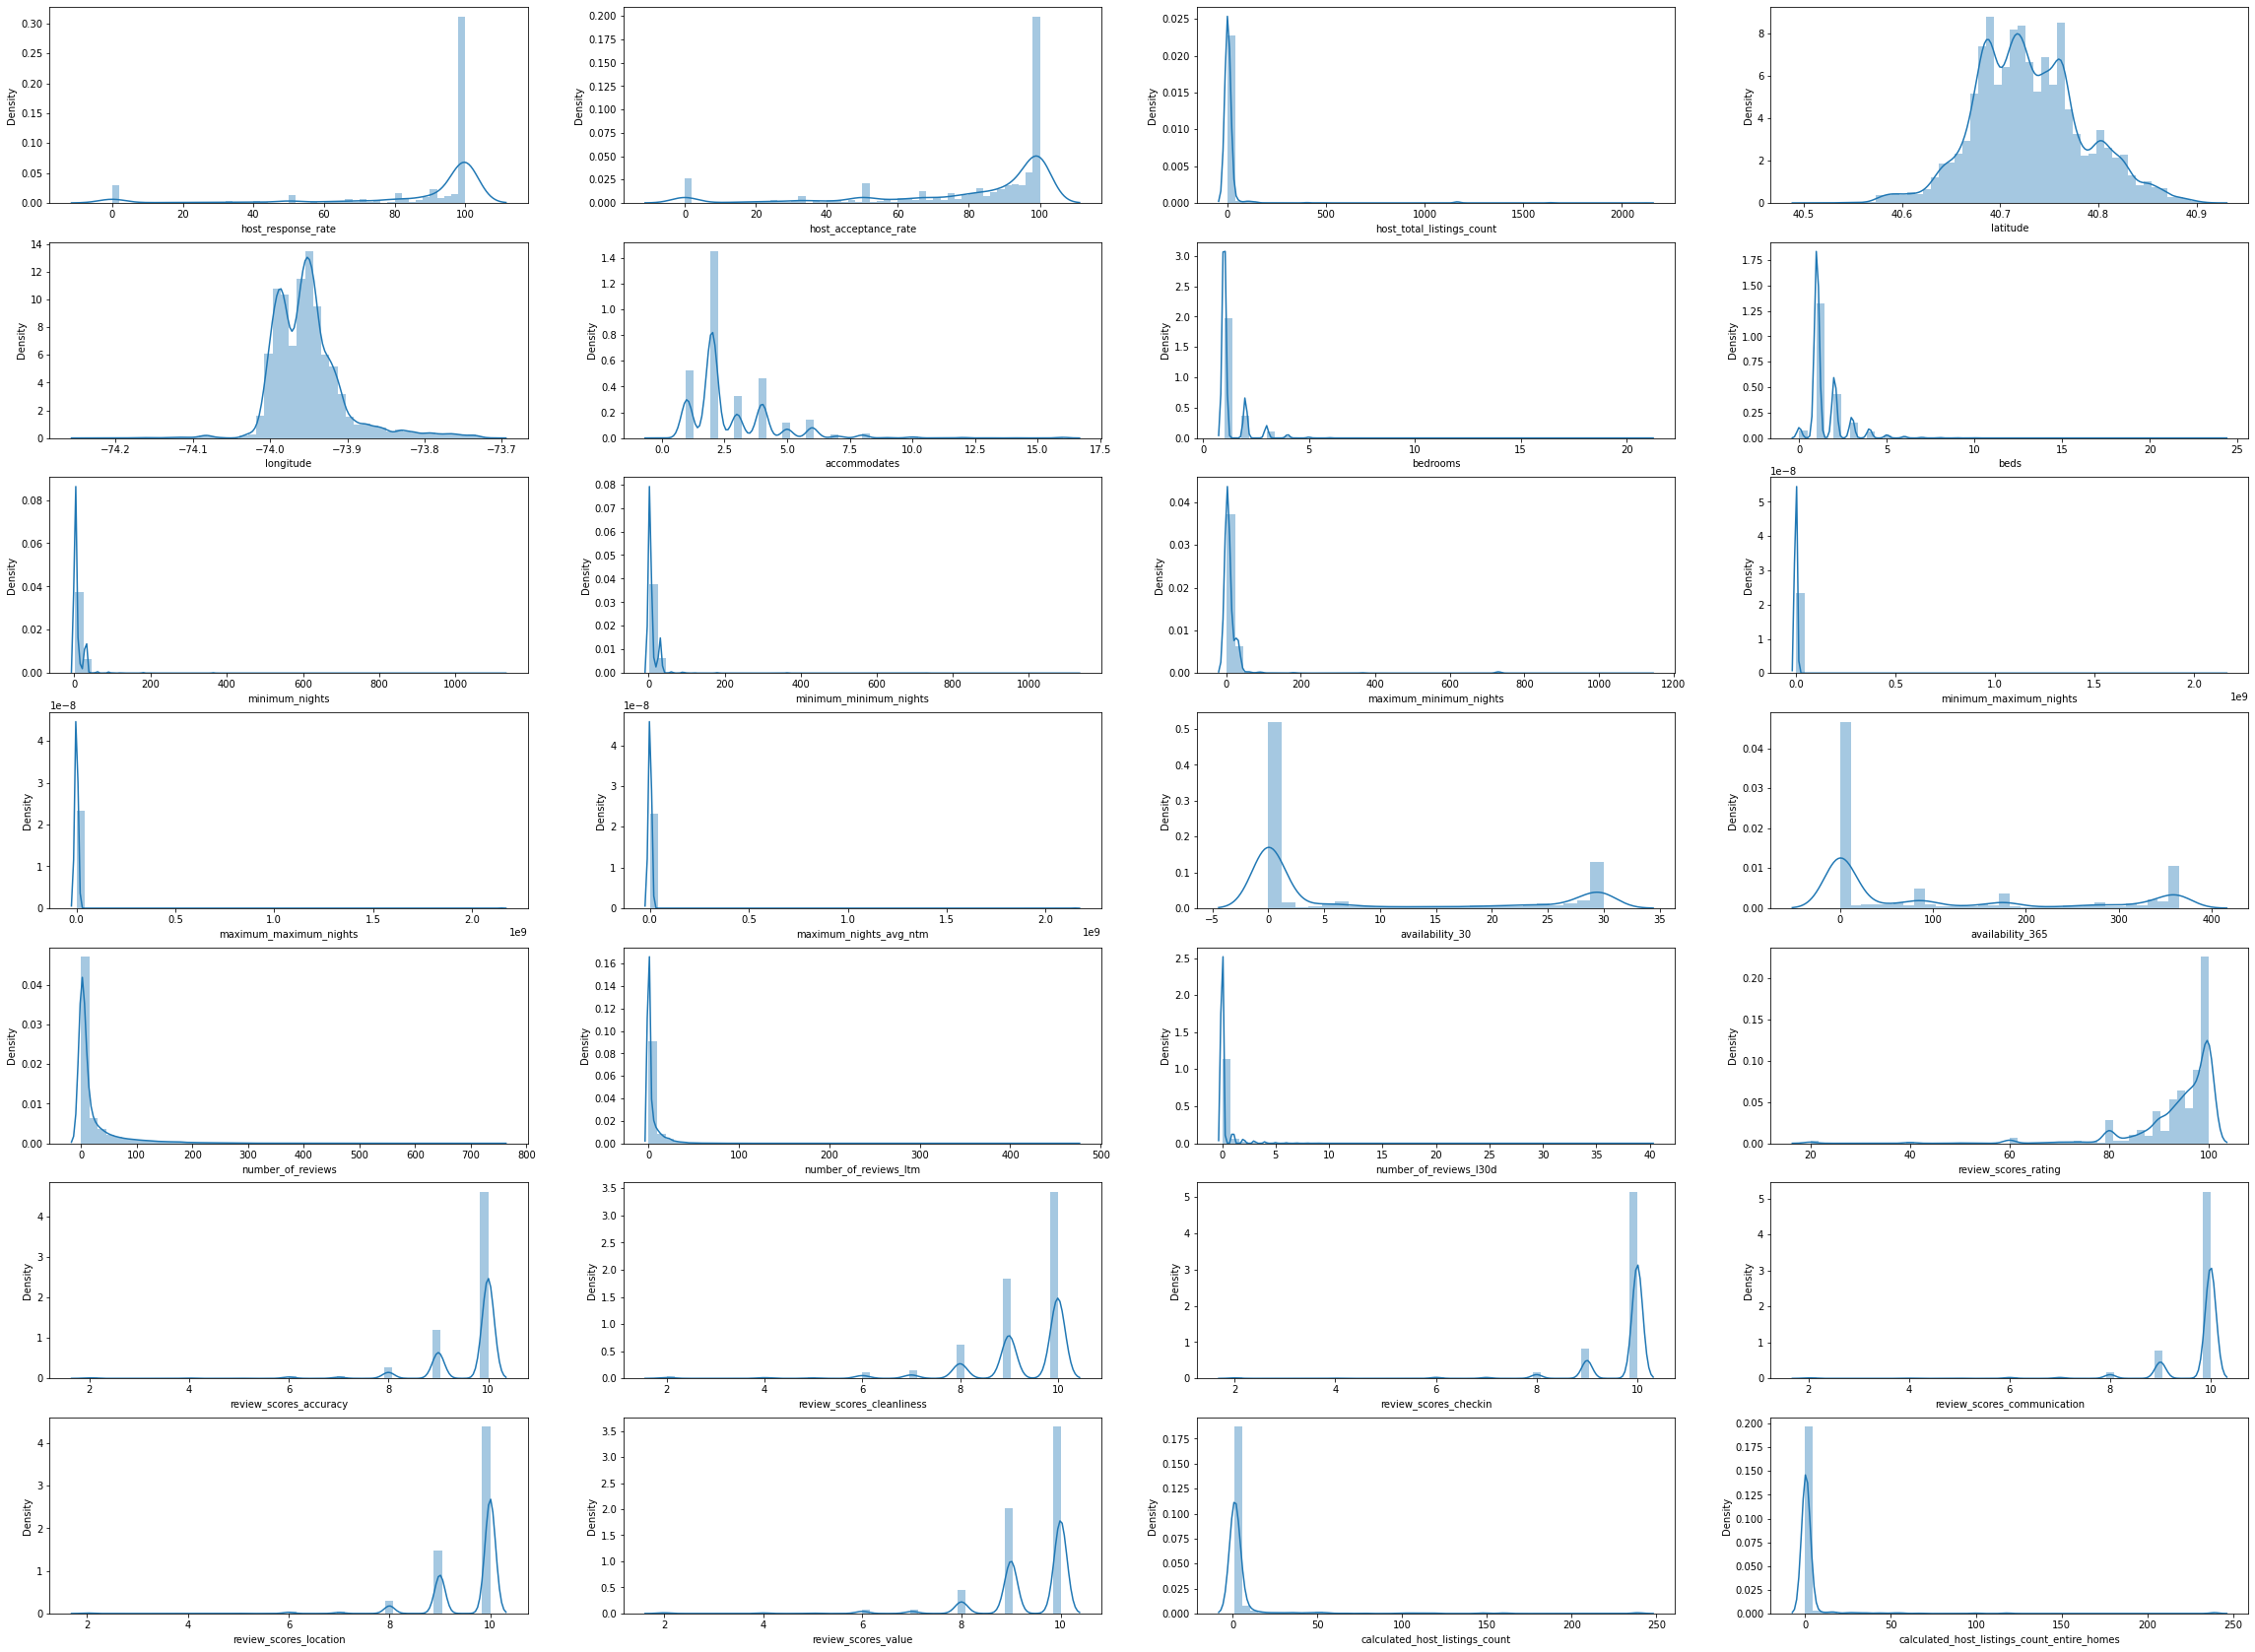

In [ ]:
# let's see how data is distributed for every column
plt.figure(figsize=(40,30), facecolor='white')
plotnumber = 1

for column in df_train[numerical_cols]:
    if plotnumber<=28 :     # as there are 28 columns in the data
        ax = plt.subplot(7,4,plotnumber)
        sns.distplot(df_train[column])
        plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

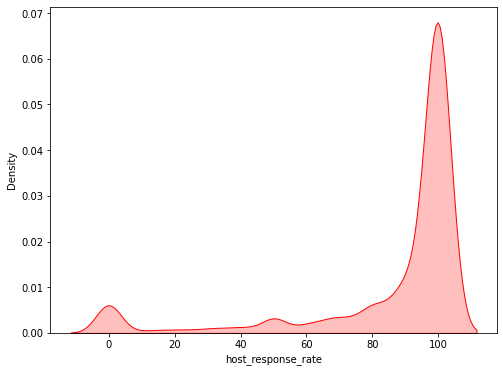

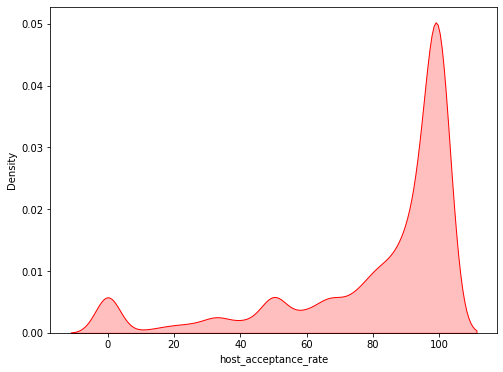

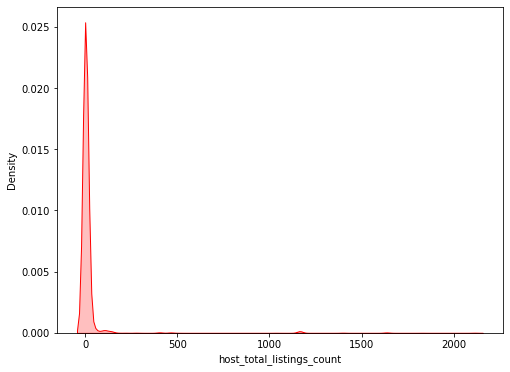

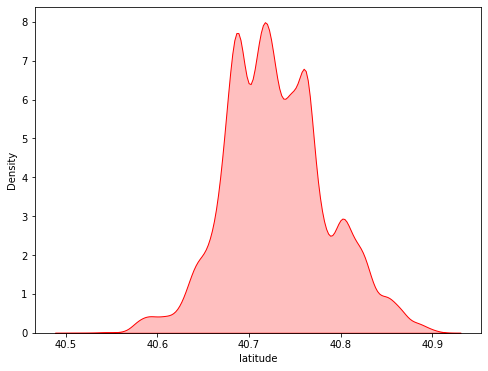

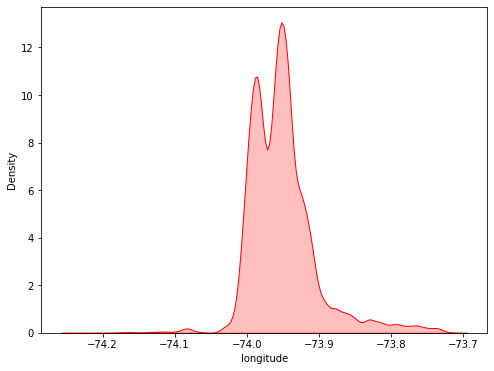

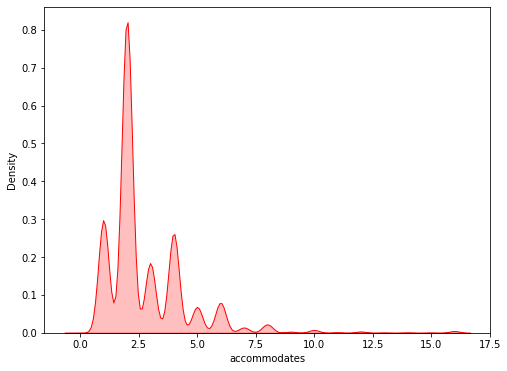

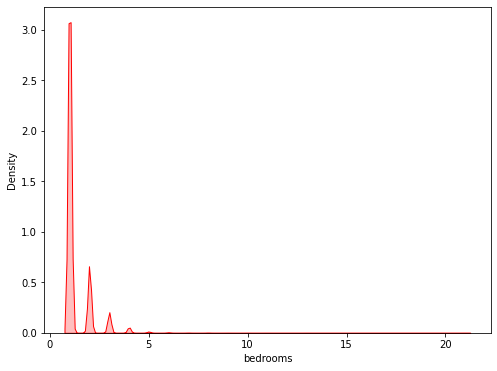

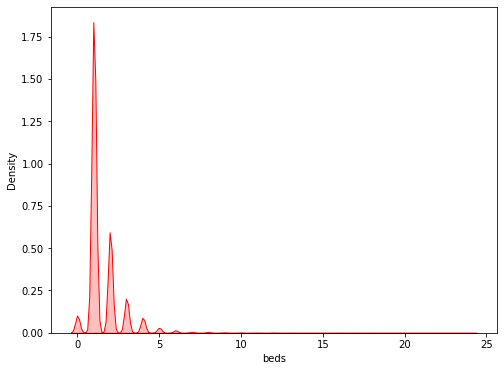

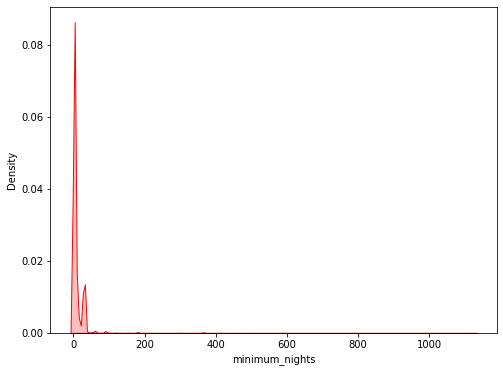

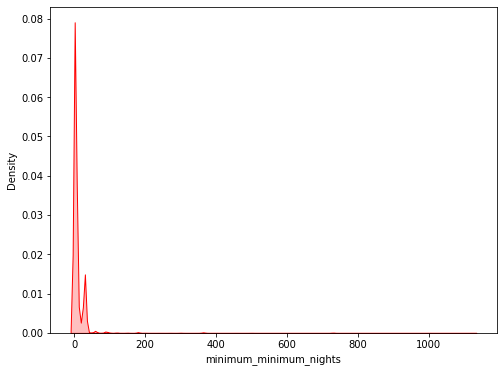

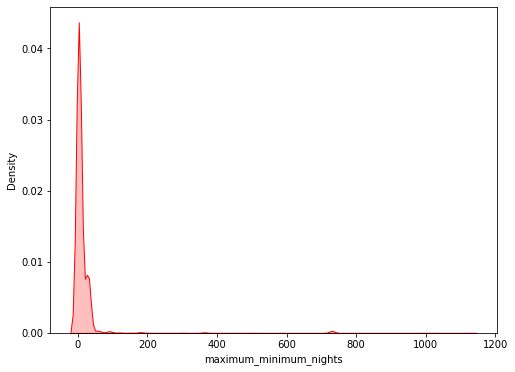

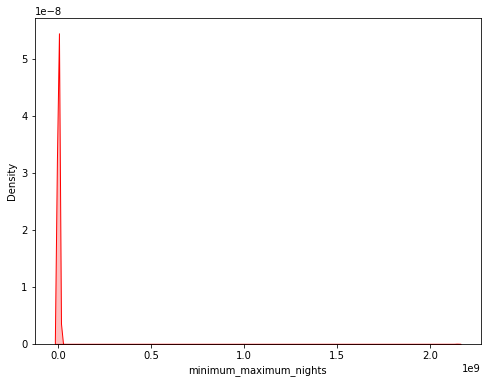

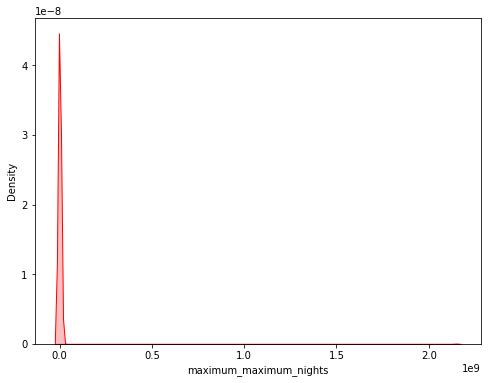

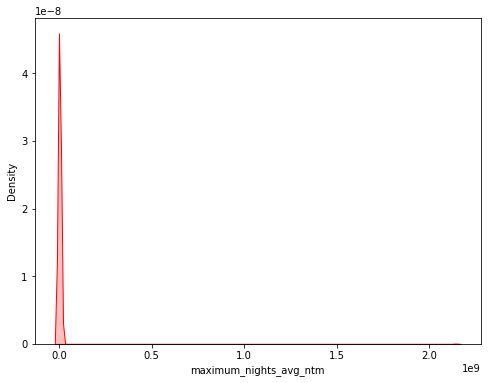

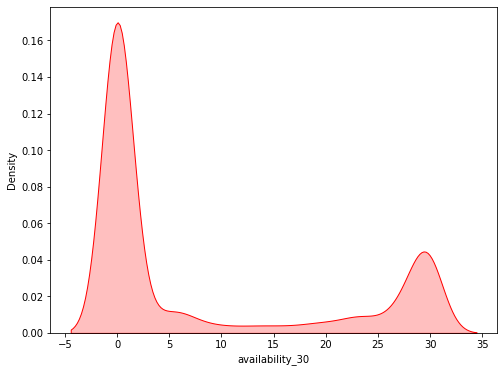

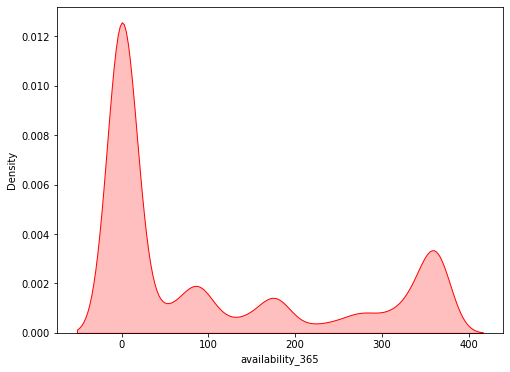

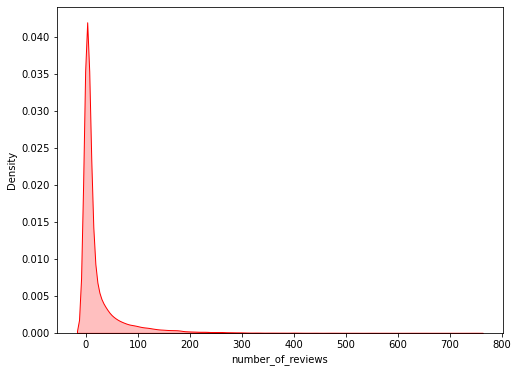

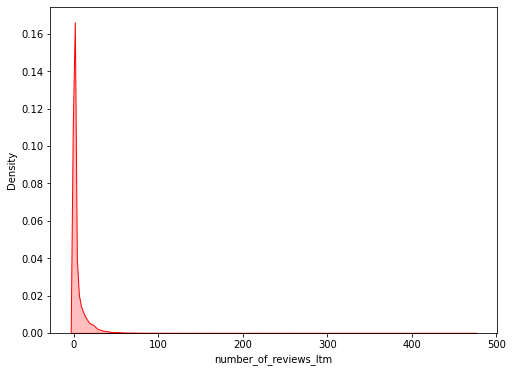

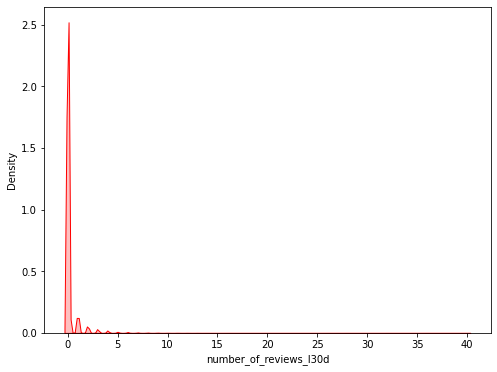

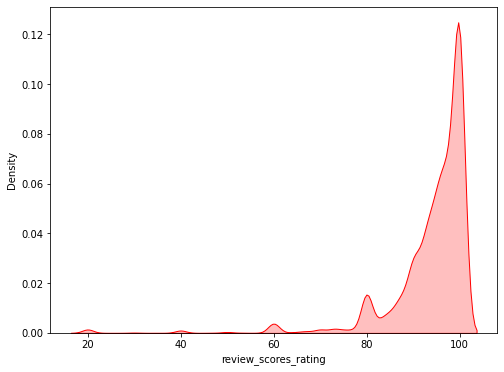

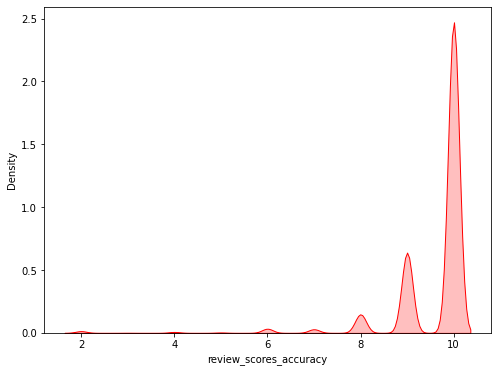

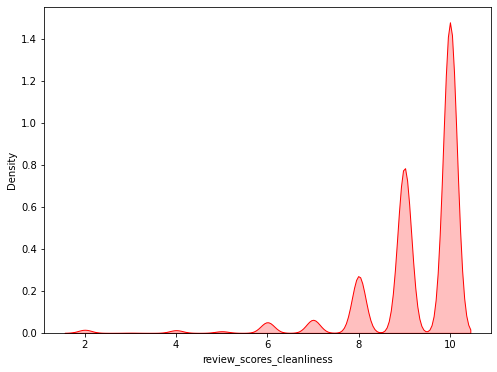

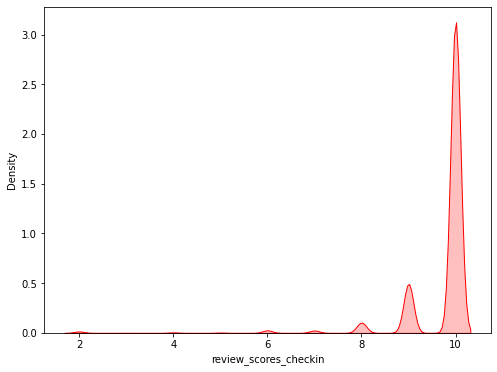

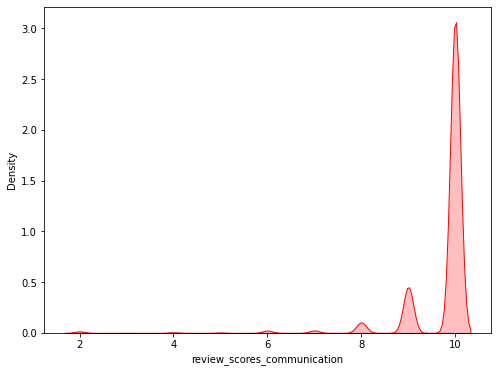

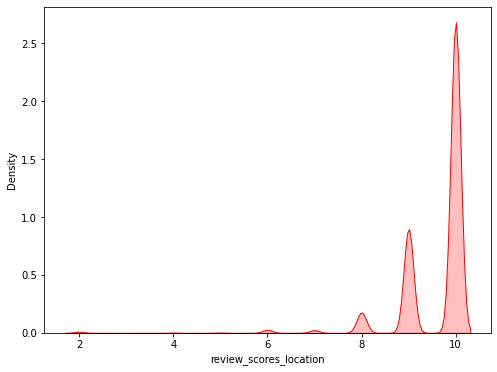

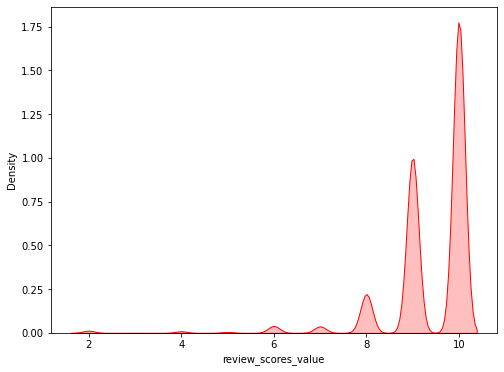

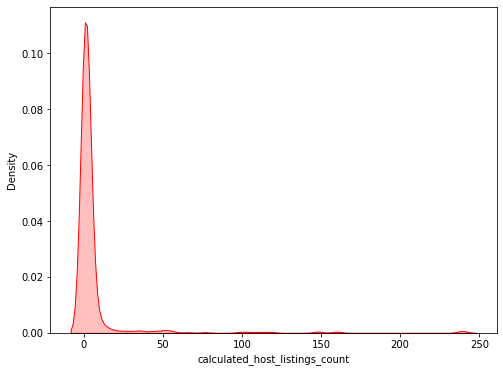

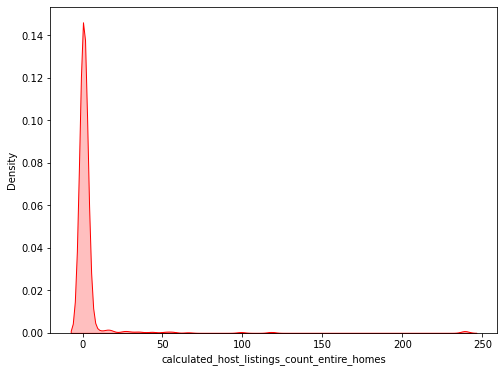

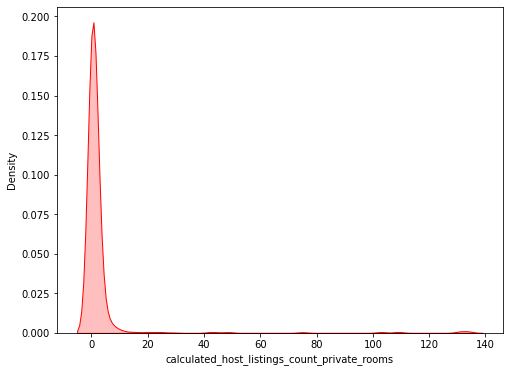

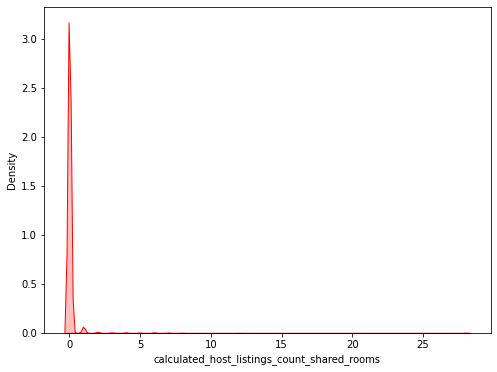

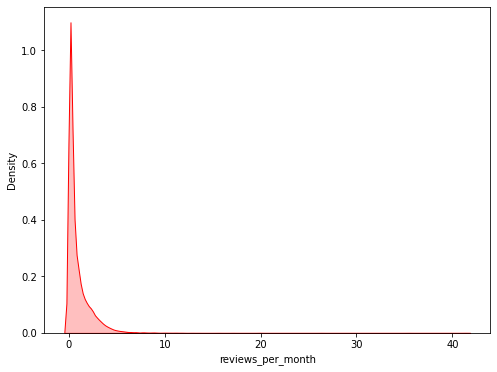

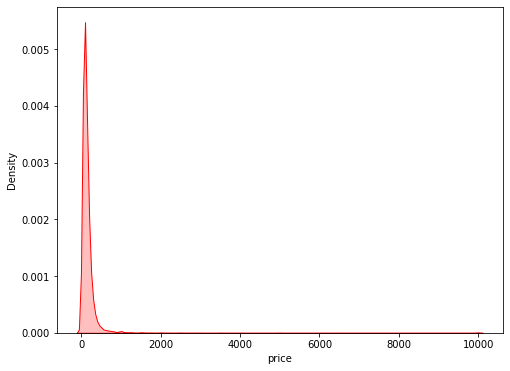

In [ ]:
# KDE Plot
for col in df_train[numerical_cols].columns:
    plt.figure(figsize= (8,6))
    ax = sns.kdeplot(df_train[col], shade=True, color="r")
    plt.show()

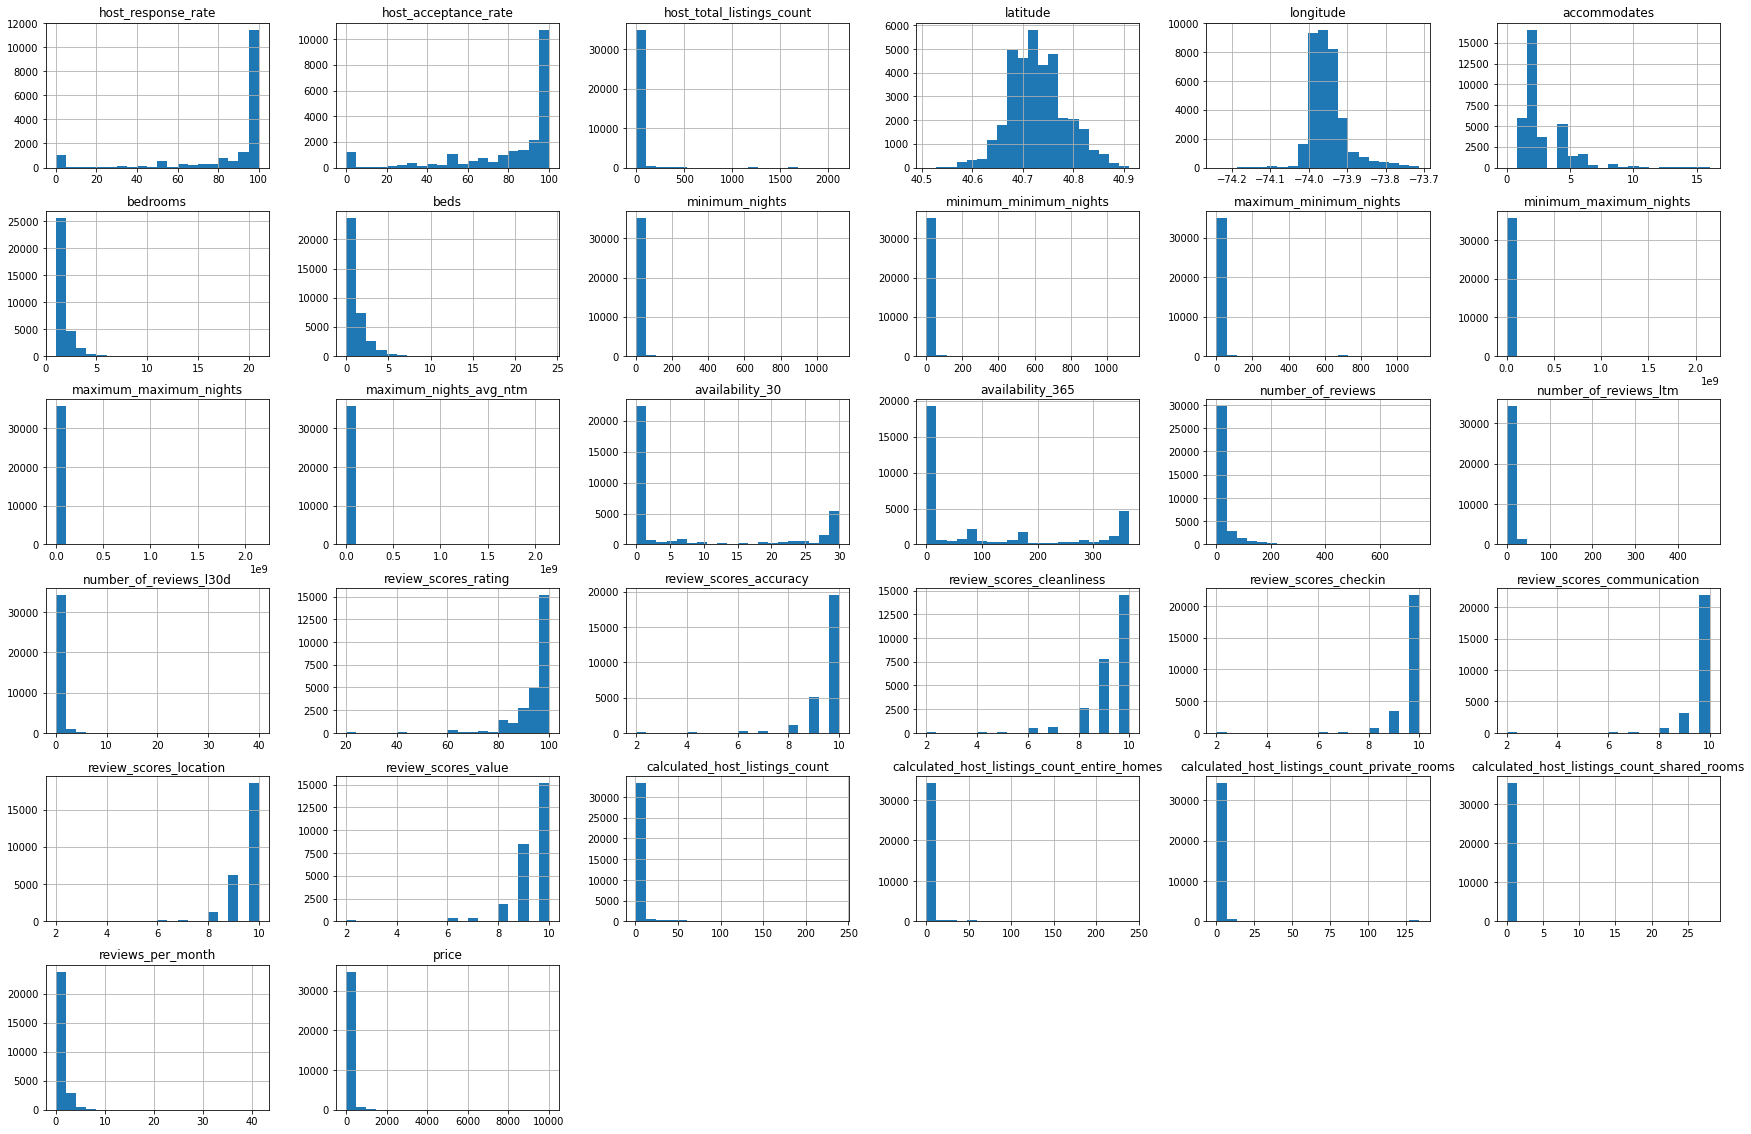

In [ ]:
# Visualize histogram of dataset
df_train[numerical_cols].hist(figsize= (30,20), bins= 20)
plt.show()

In [ ]:
# diagnostic plot to confirm skewness/outliers
def diagnostic_plots(df,variable):
  # functin to plot a histogram and Q-Q plot 
  
  plt.figure(figsize = (15,6))
  plt.subplot(1,2,1)
  df[variable].hist()
  plt.title(str(variable))
  
  plt.subplot(1,2,2)
  stats.probplot(df[variable], dist = "norm", plot = plt)
  plt.title(str(variable))
  
  plt.show()

<Figure size 1008x864 with 0 Axes>

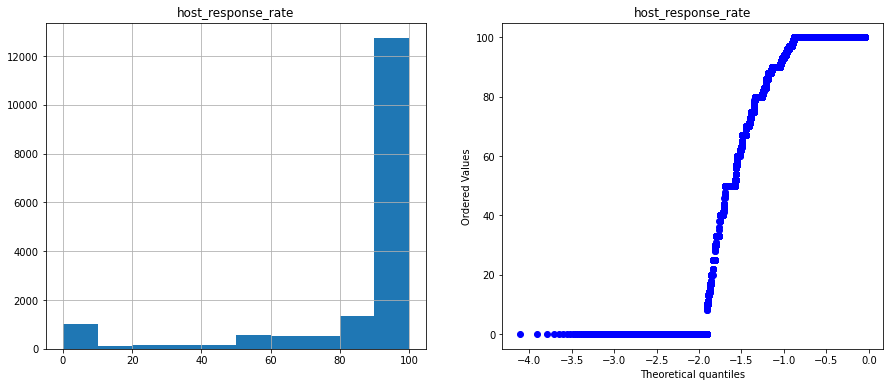

<Figure size 1008x864 with 0 Axes>

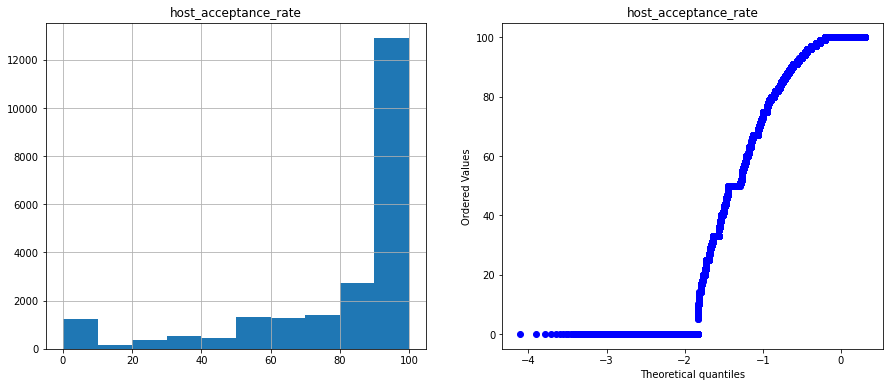

<Figure size 1008x864 with 0 Axes>

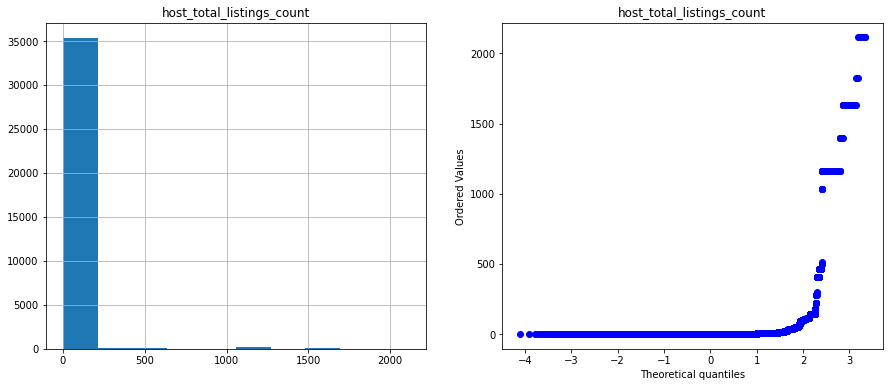

<Figure size 1008x864 with 0 Axes>

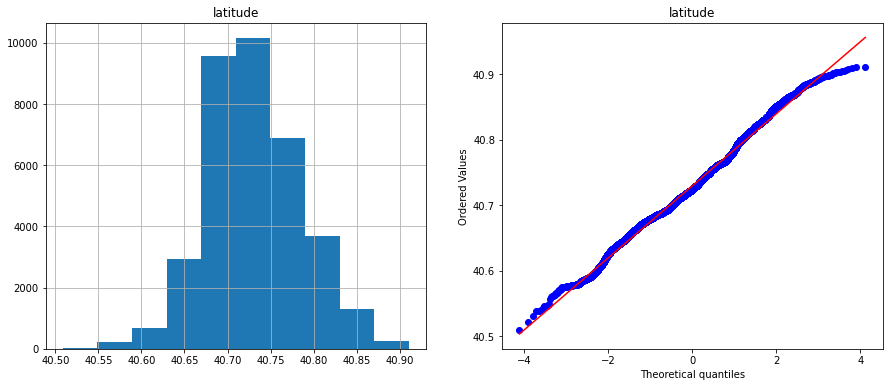

<Figure size 1008x864 with 0 Axes>

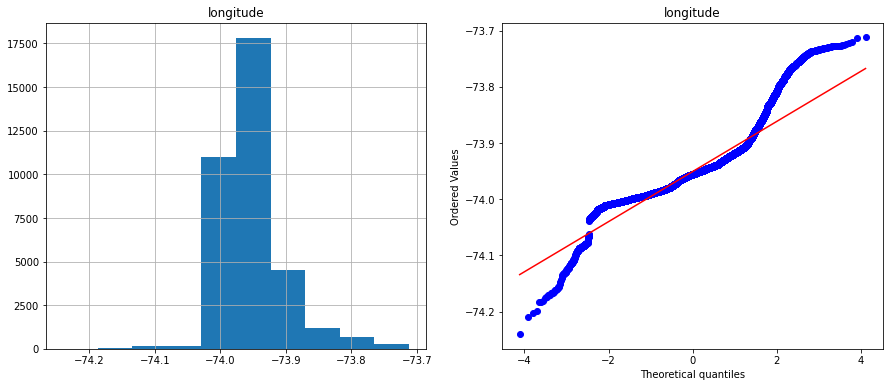

<Figure size 1008x864 with 0 Axes>

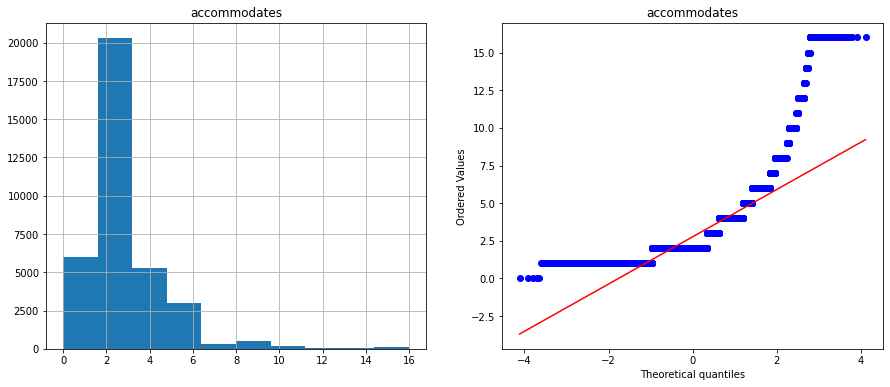

<Figure size 1008x864 with 0 Axes>

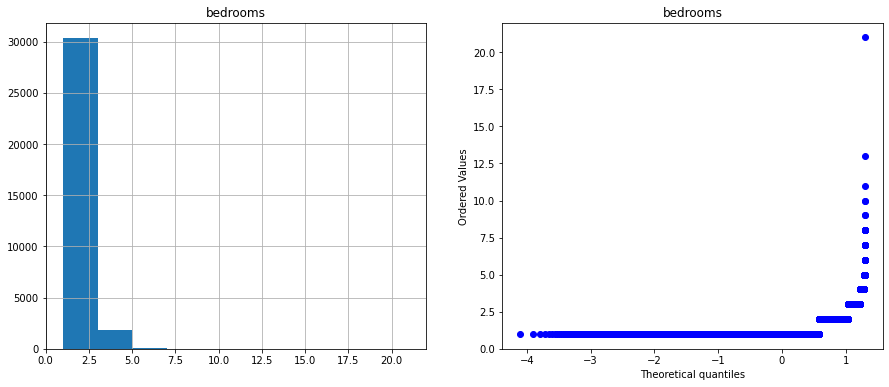

<Figure size 1008x864 with 0 Axes>

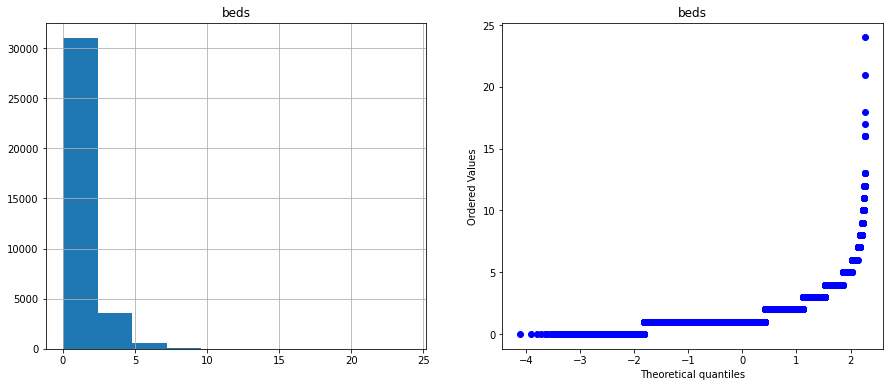

<Figure size 1008x864 with 0 Axes>

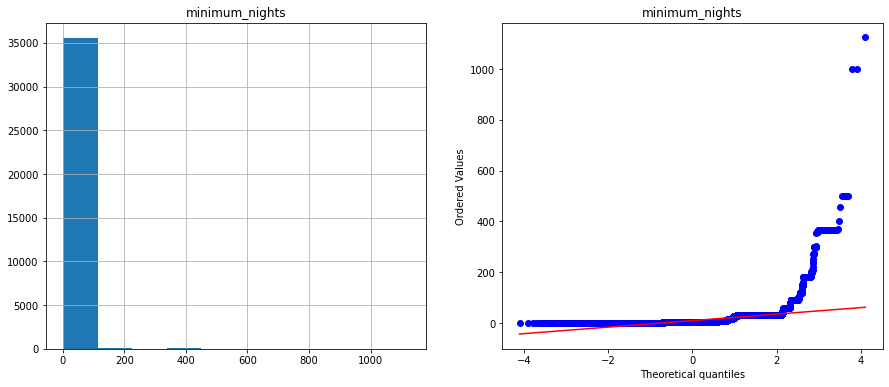

<Figure size 1008x864 with 0 Axes>

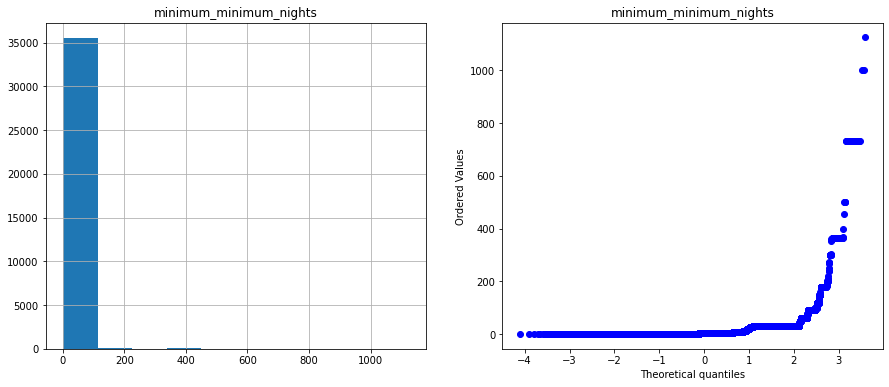

<Figure size 1008x864 with 0 Axes>

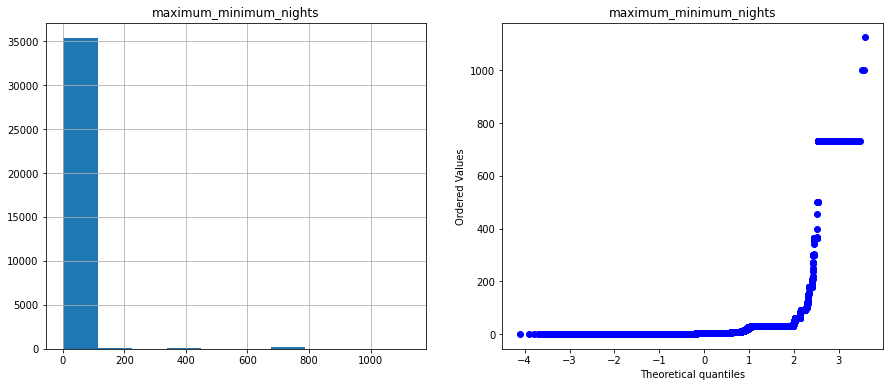

<Figure size 1008x864 with 0 Axes>

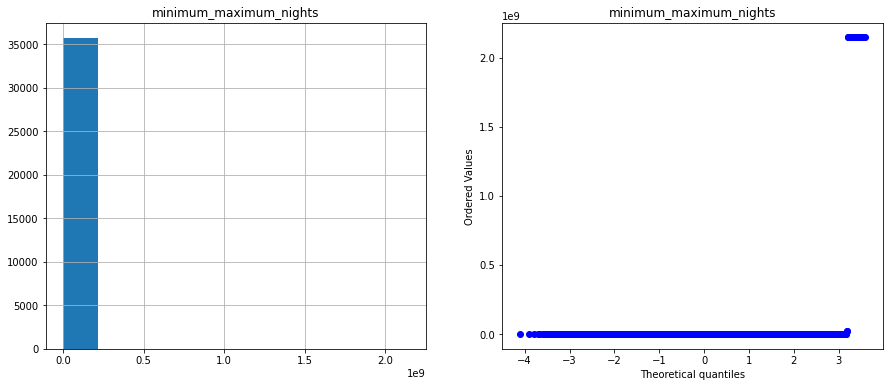

<Figure size 1008x864 with 0 Axes>

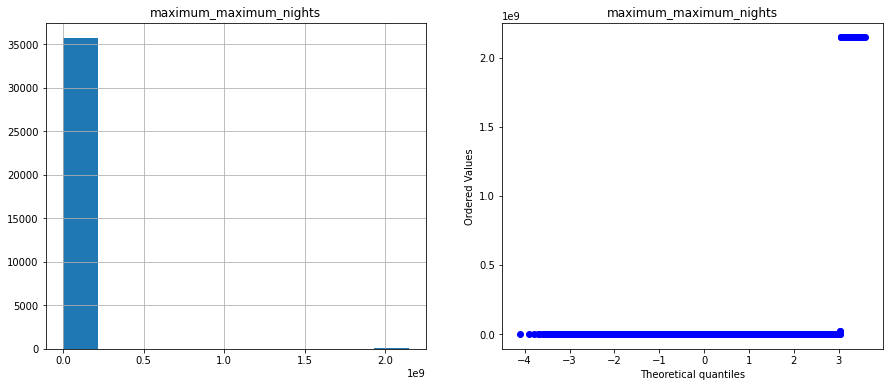

<Figure size 1008x864 with 0 Axes>

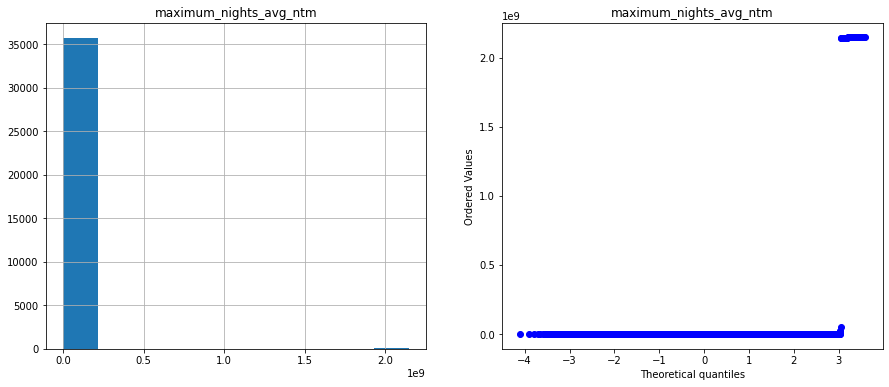

<Figure size 1008x864 with 0 Axes>

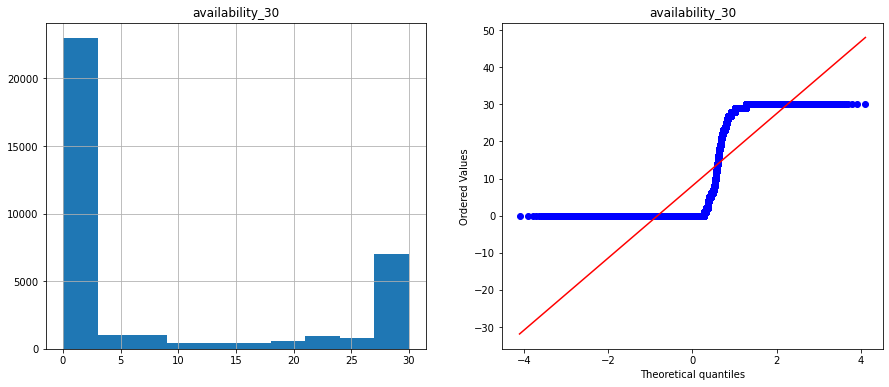

<Figure size 1008x864 with 0 Axes>

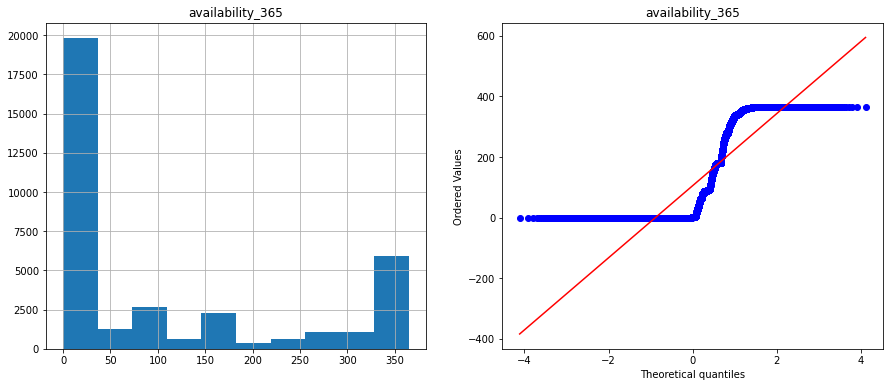

<Figure size 1008x864 with 0 Axes>

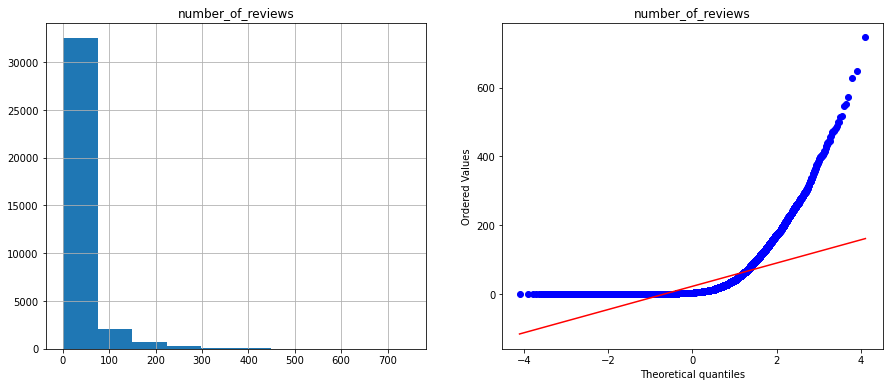

<Figure size 1008x864 with 0 Axes>

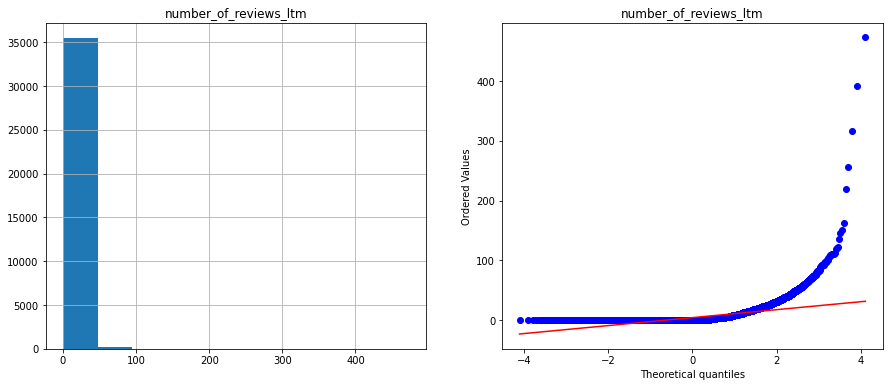

<Figure size 1008x864 with 0 Axes>

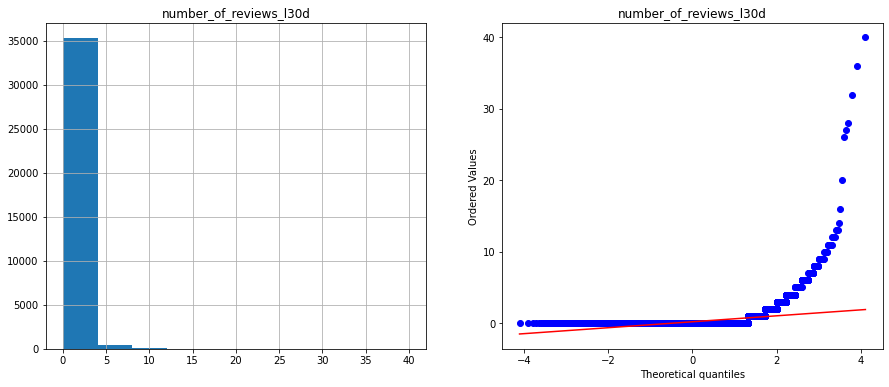

<Figure size 1008x864 with 0 Axes>

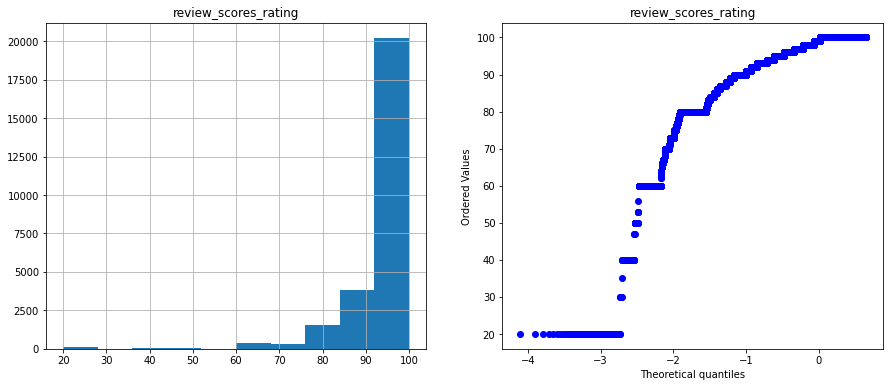

<Figure size 1008x864 with 0 Axes>

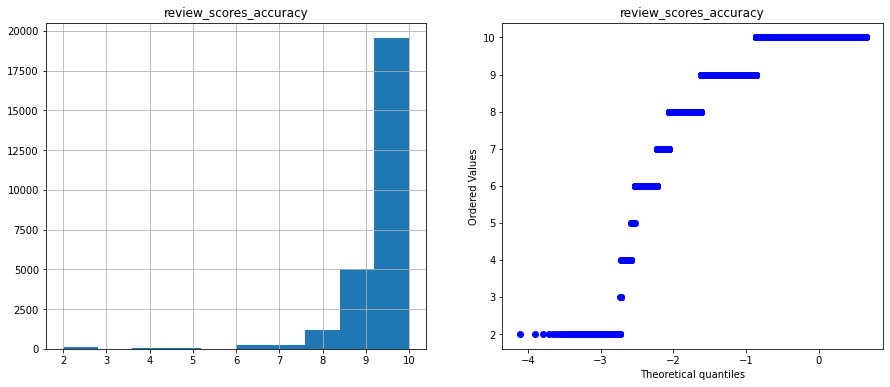

<Figure size 1008x864 with 0 Axes>

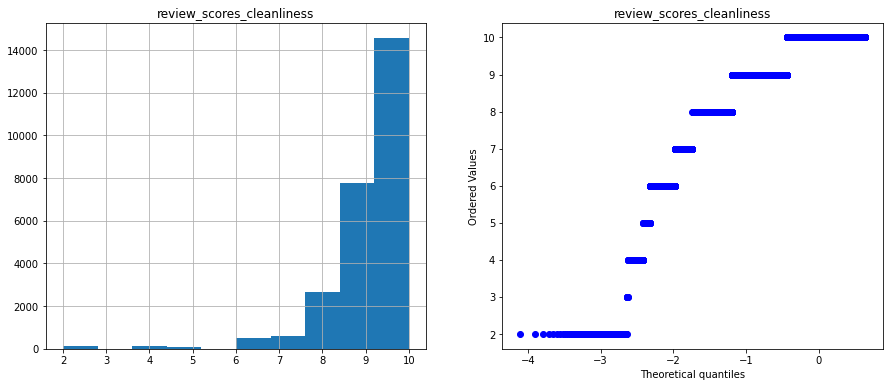

<Figure size 1008x864 with 0 Axes>

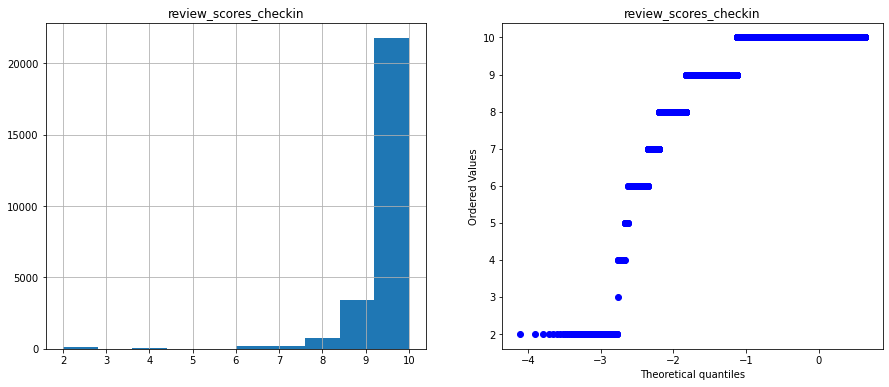

<Figure size 1008x864 with 0 Axes>

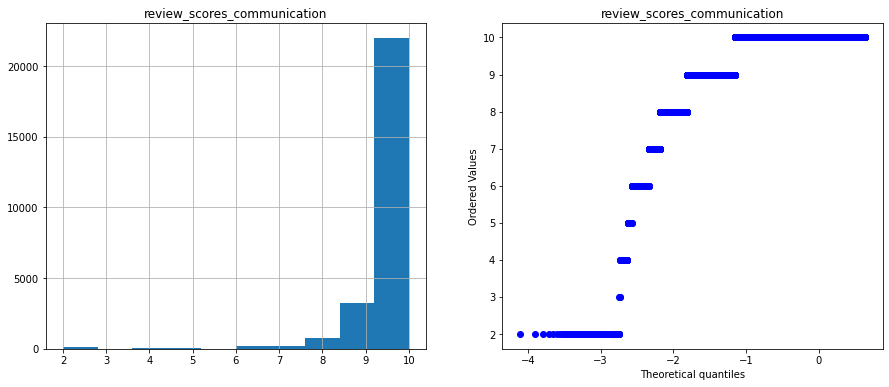

<Figure size 1008x864 with 0 Axes>

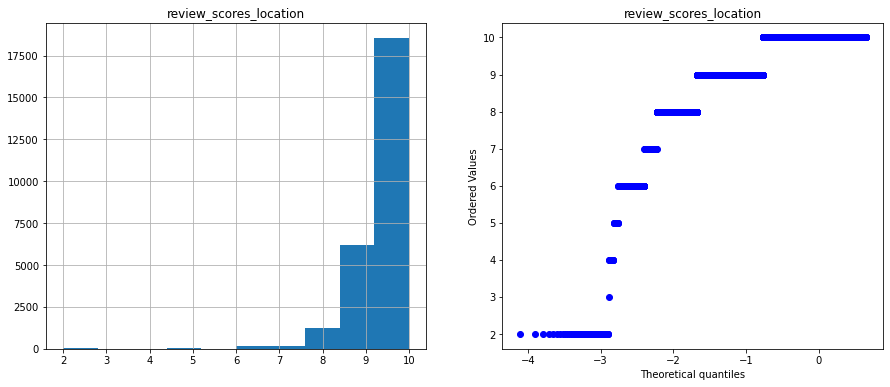

<Figure size 1008x864 with 0 Axes>

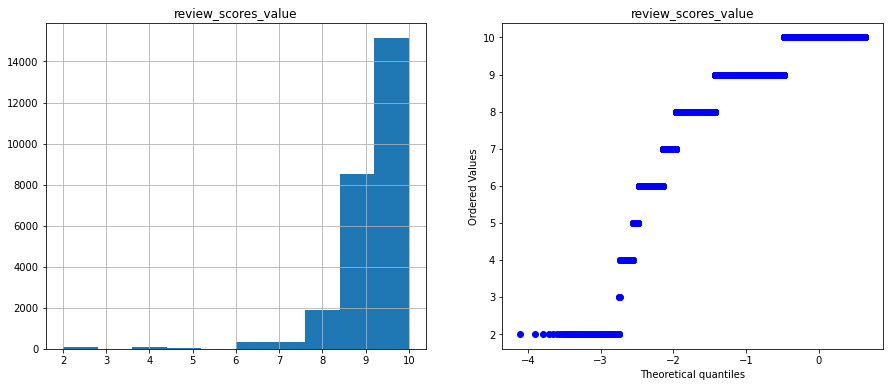

<Figure size 1008x864 with 0 Axes>

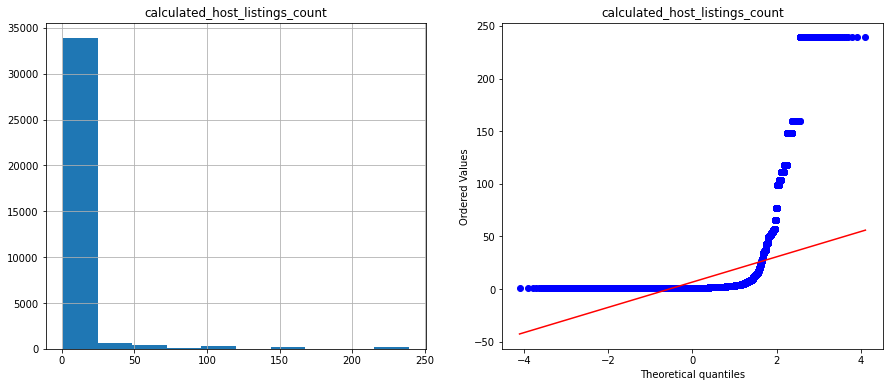

<Figure size 1008x864 with 0 Axes>

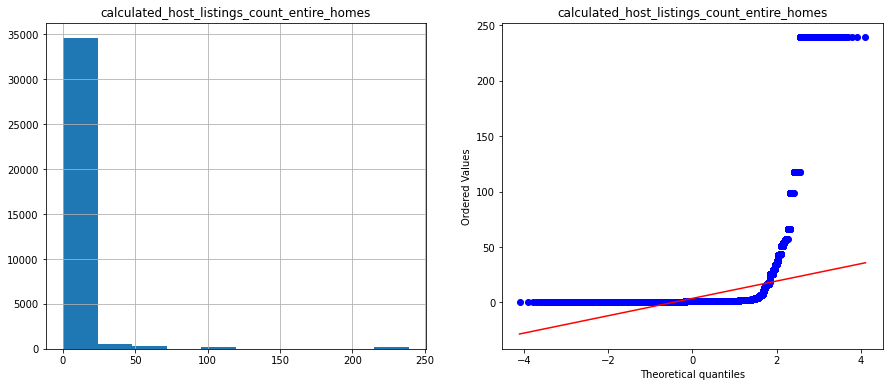

<Figure size 1008x864 with 0 Axes>

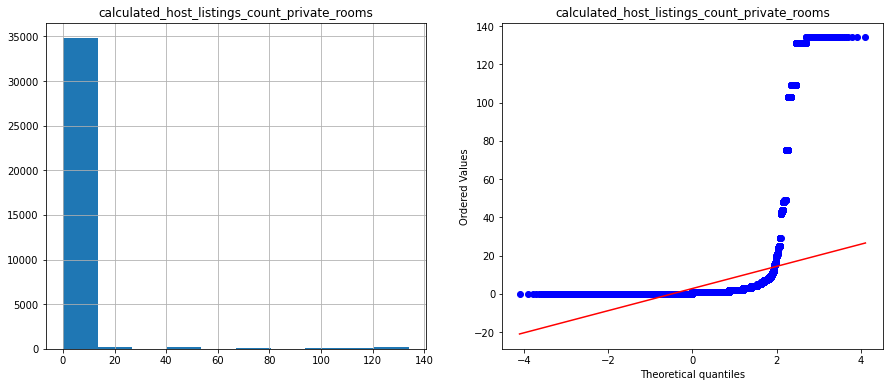

<Figure size 1008x864 with 0 Axes>

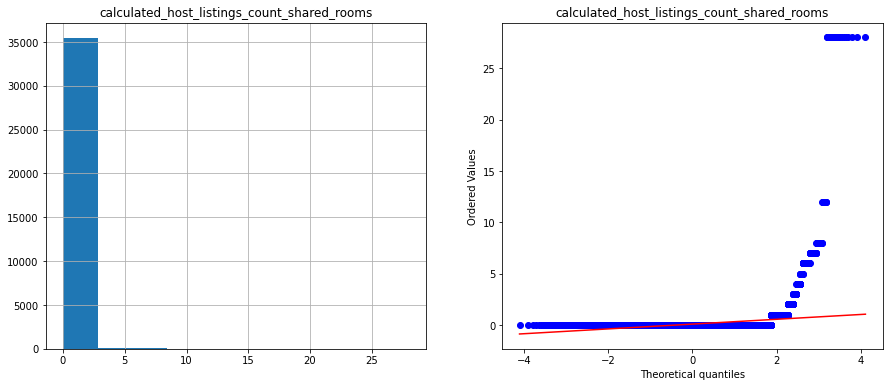

<Figure size 1008x864 with 0 Axes>

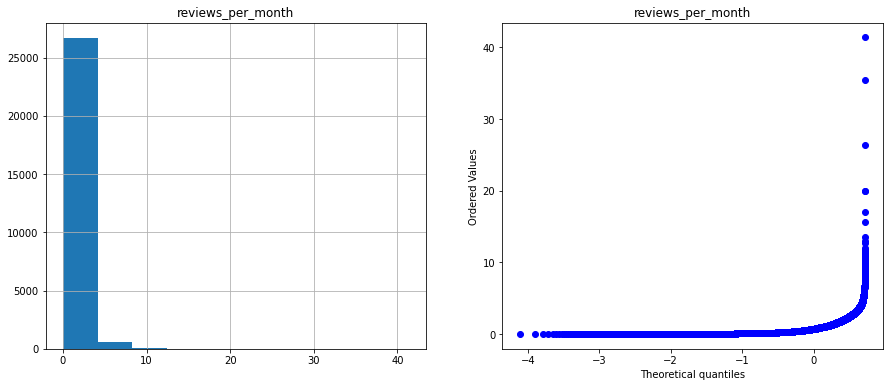

<Figure size 1008x864 with 0 Axes>

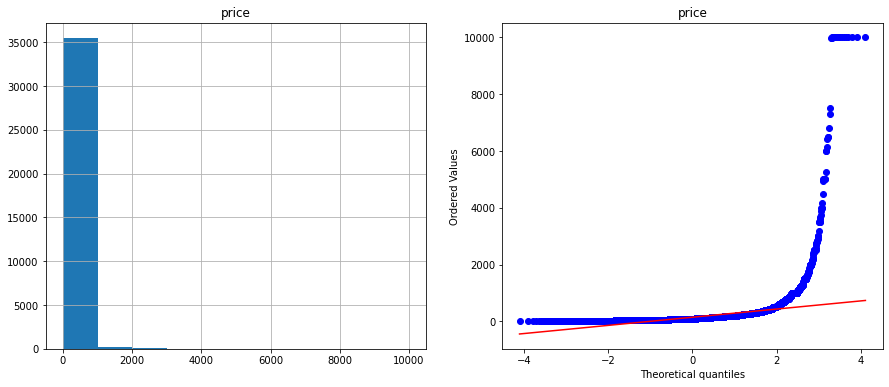

In [ ]:
# Confirm skewness with Q-Q plot for all numerical columns
for i,cols in enumerate(df_train[numerical_cols].columns):
    plt.figure(i)
    diagnostic_plots(df_train[numerical_cols], cols)
    plt.show()

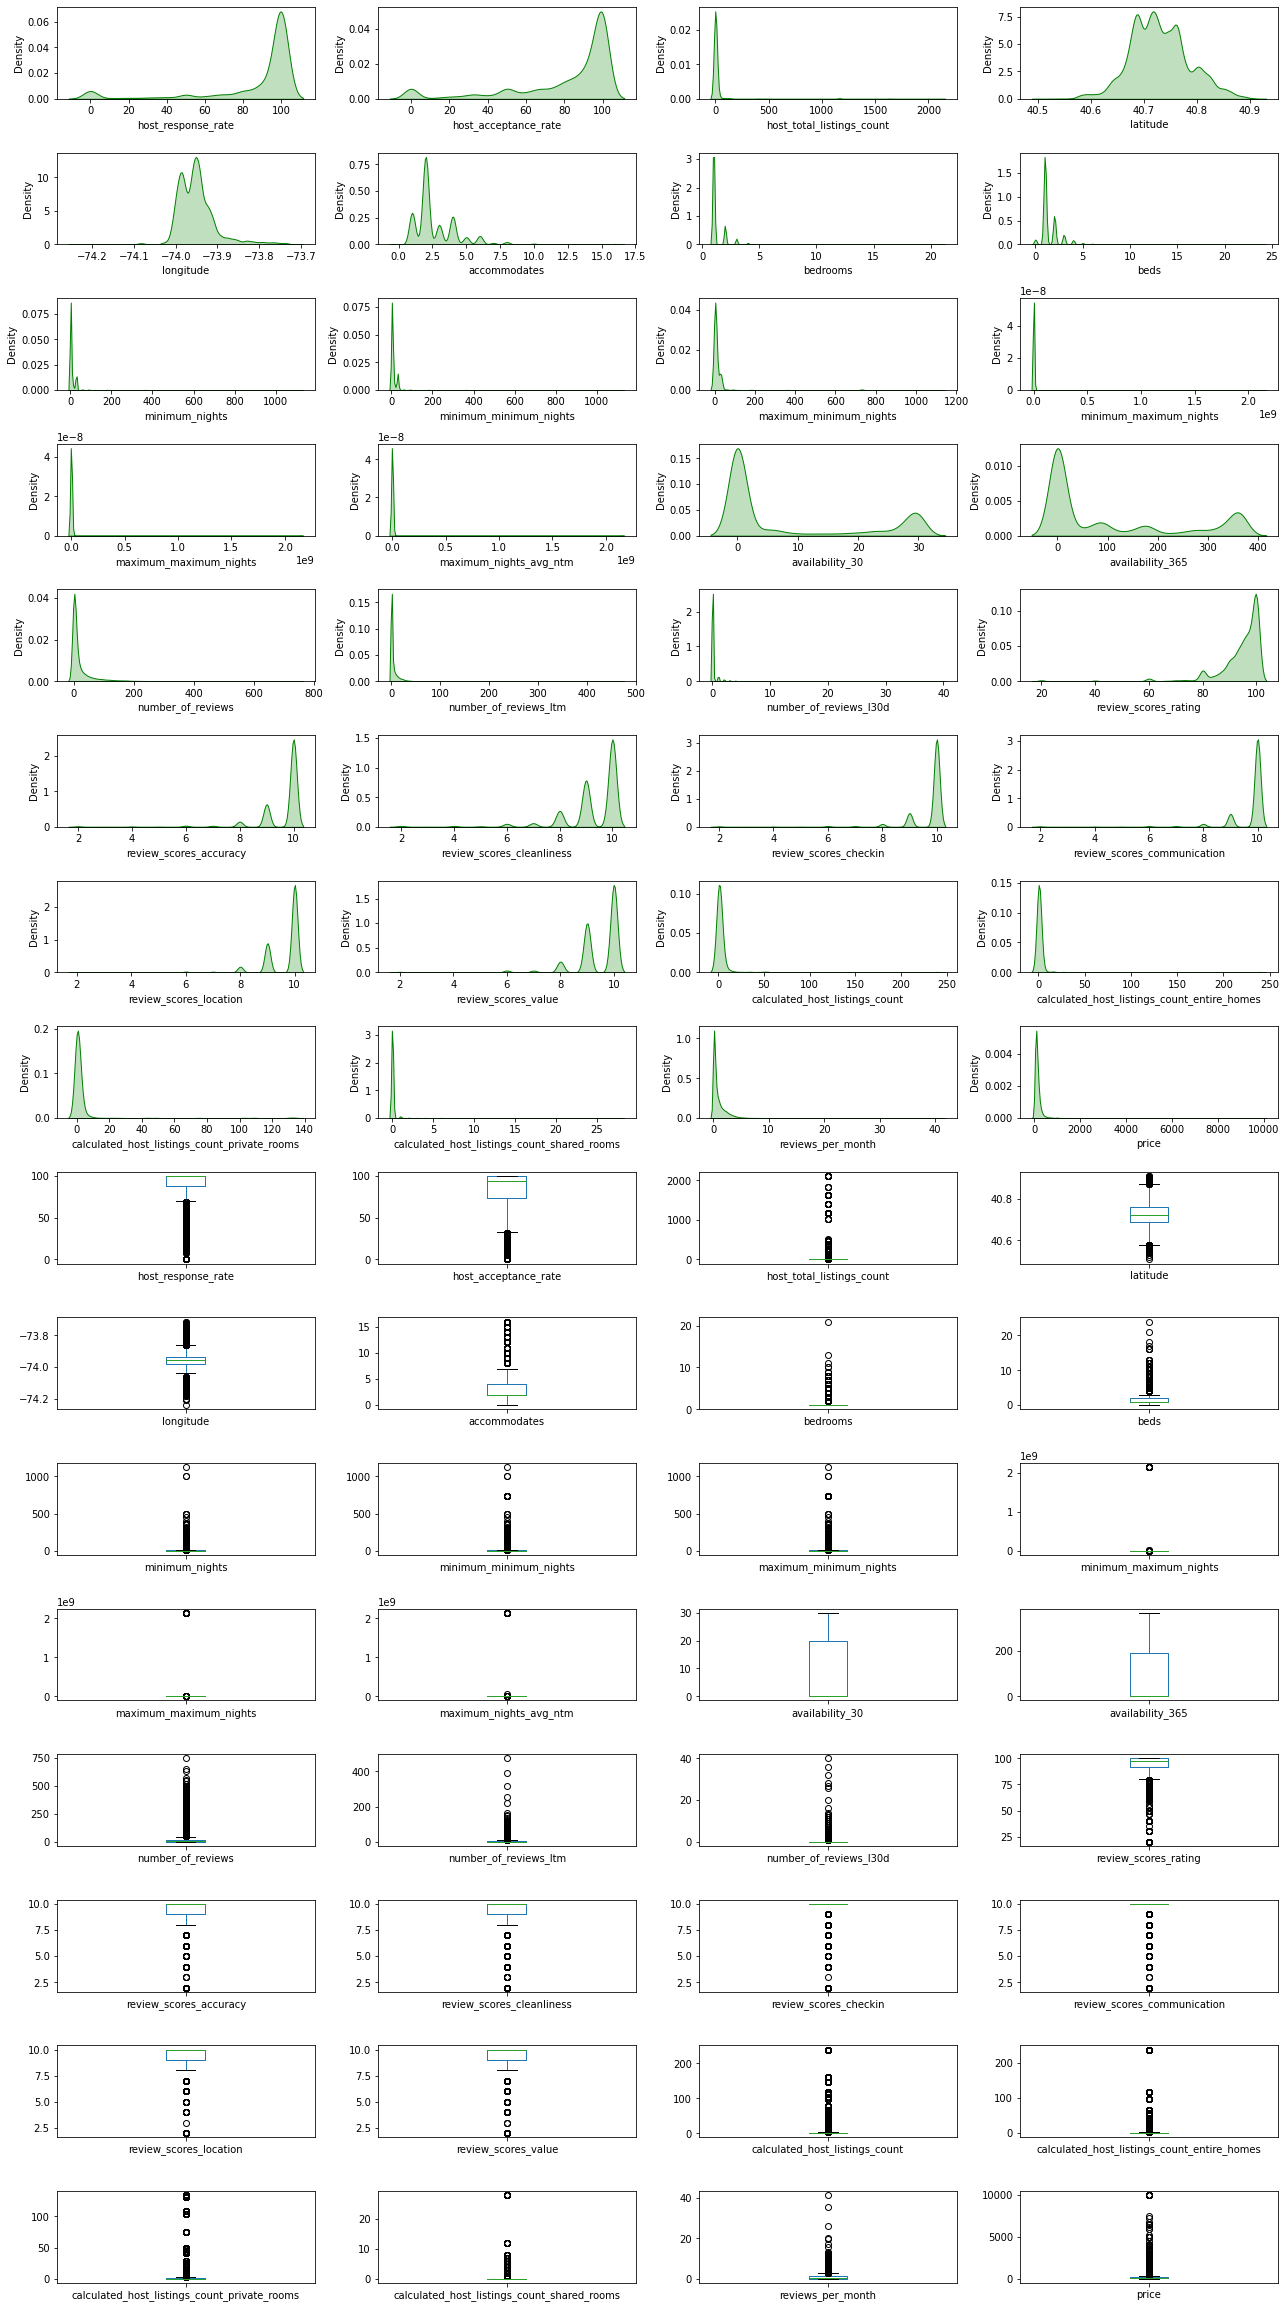

,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,maximum_nights_avg_ntm,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
skewness,-2.235234,-1.676269,11.166757,0.225187,1.378141,2.577353,3.895359,3.453891,14.920431,16.658228,11.222587,43.329237,31.455663,31.902548,1.007455,0.918440,3.974457,9.472685,12.808857,-3.792747,-4.217875,-2.772914,-5.336053,-5.406851,-3.852578,-3.205840,6.658438,9.746966,7.989467,22.579991,4.951304,21.012058
kurtosis,3.938507,1.912440,134.376664,0.106051,4.558171,11.122734,37.704525,26.260225,414.982213,397.175773,135.125891,1875.544658,987.518714,1015.850563,-0.818817,-0.825404,22.384706,262.279083,344.901927,21.210135,25.280667,11.290891,39.099867,39.152915,25.242827,16.369466,49.812464,105.262282,66.095969,637.932583,78.455445,593.256341


In [ ]:
# Visual exploration of numerical colums
plt.figure(figsize= (18,40))

for i,col in enumerate(numerical_cols,1):
    plt.subplot(20,4,i)
    sns.kdeplot(df_train[col],color='g',shade=True)
    plt.subplot(20,4, i+len(numerical_cols))
    df_train[col].plot.box()
plt.tight_layout() 
plt.show()


num_data = df_train[numerical_cols]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

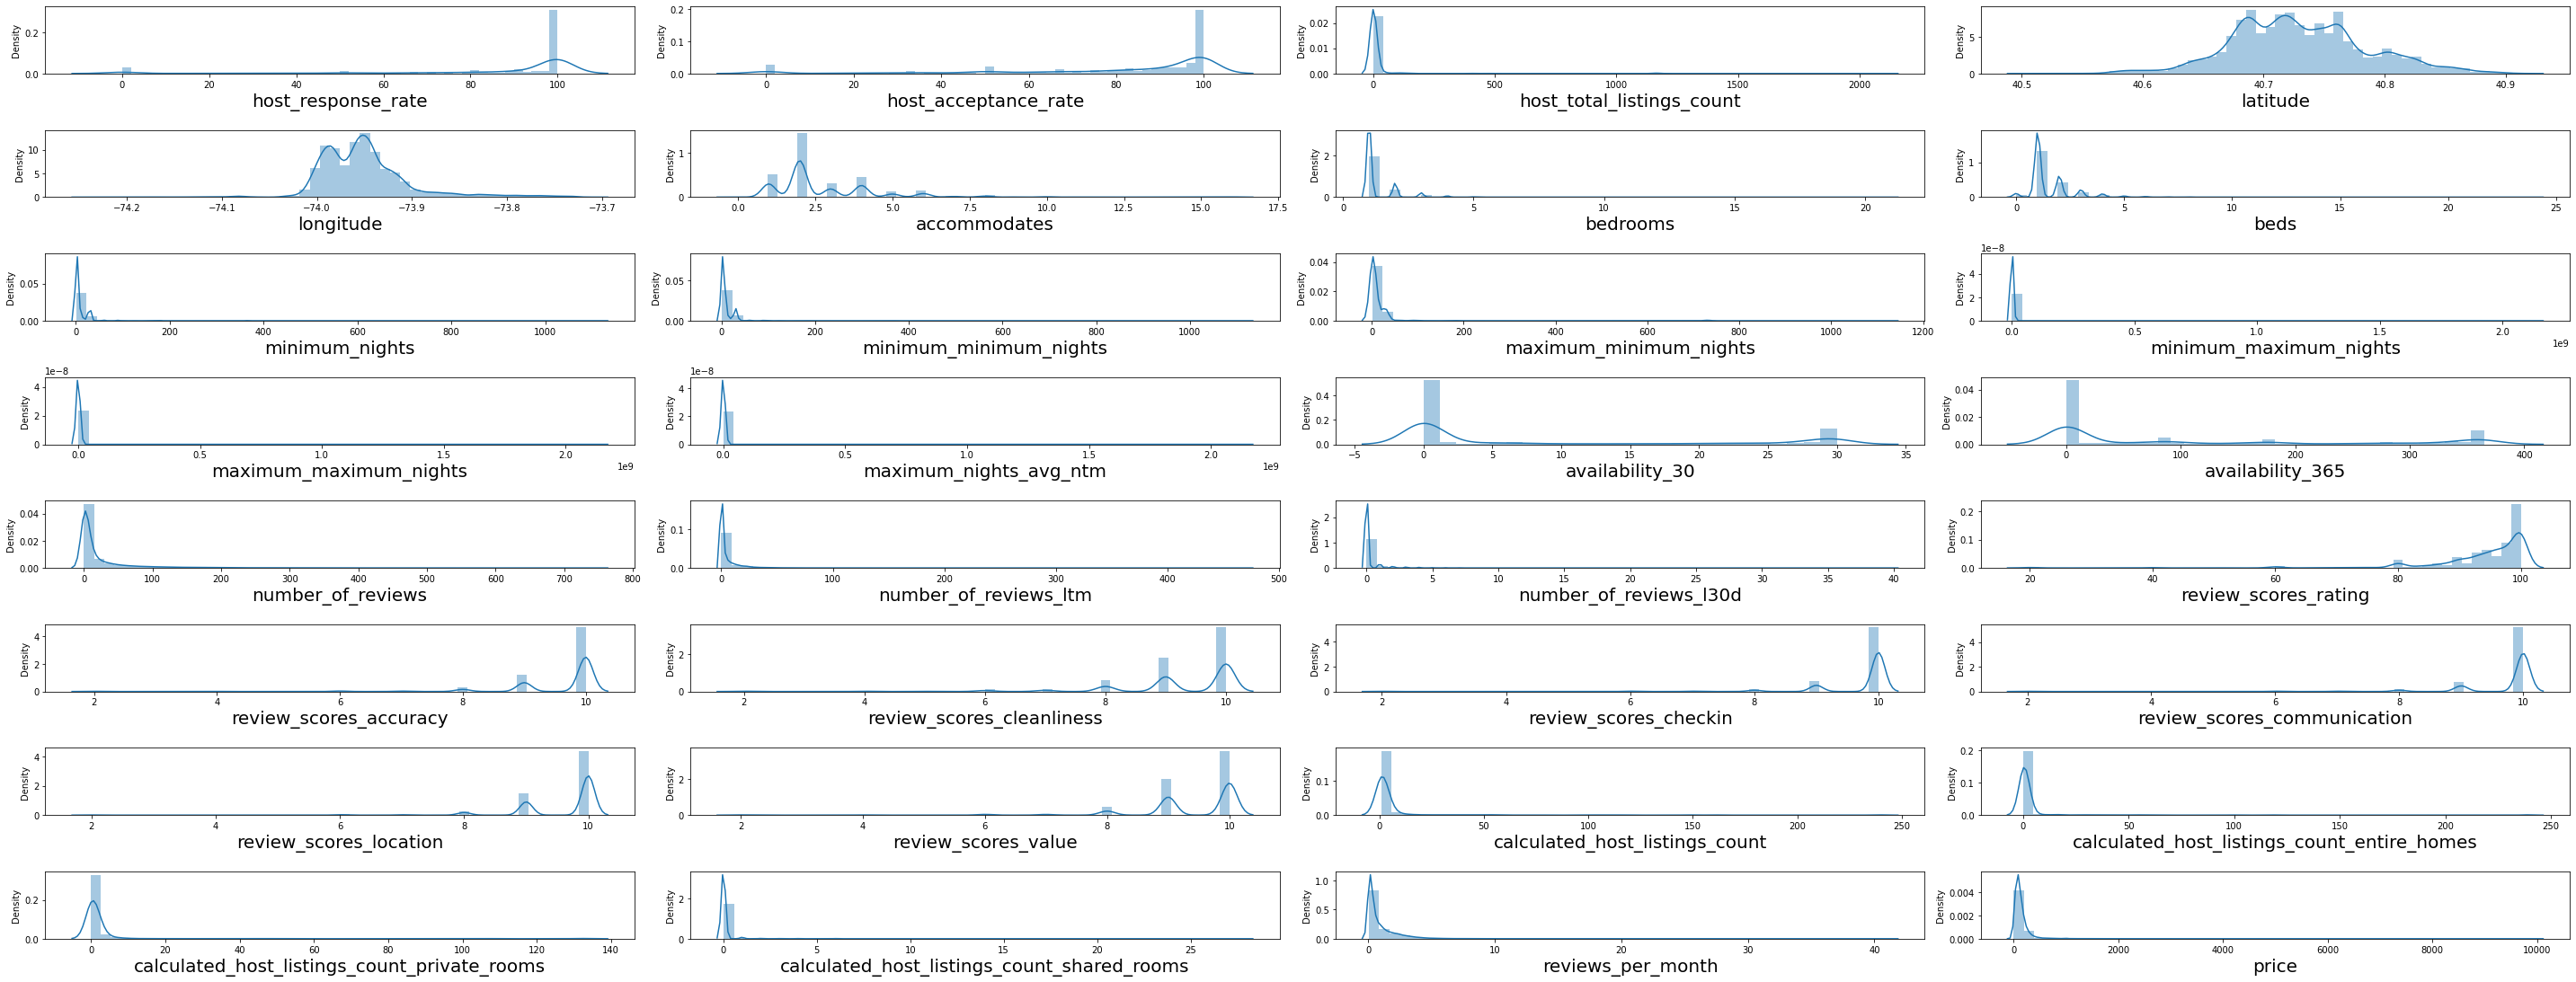

In [ ]:
# let's see how data is distributed for every column
plt.figure(figsize=(40,30), facecolor='white')
plotnumber = 1

for column in numerical_cols:
    if plotnumber<=64 :
        ax = plt.subplot(16,4,plotnumber)
        sns.distplot(df_train[column])
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('Salary',fontsize=20)
    plotnumber+=1
plt.tight_layout()

#### Adressing missing values

In [ ]:
# Visualize the missing values in train dataframe by column
df_train.isnull().sum()

name                                               12
description                                      1017
neighborhood_overview                           13150
picture_url                                         0
host_name                                          14
                                                ...  
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                                8399
price                                               0
Length: 65, dtype: int64

In [ ]:
# Visualize the missing values in test dataframe by column
df_test.isnull().sum()

host_response_rate                              4642
host_acceptance_rate                            3398
host_total_listings_count                          3
latitude                                           0
longitude                                          0
accommodates                                       0
bedrooms                                         847
beds                                             104
minimum_nights                                     0
minimum_minimum_nights                             1
maximum_minimum_nights                             1
minimum_maximum_nights                             1
maximum_maximum_nights                             1
maximum_nights_avg_ntm                             1
availability_30                                    0
availability_365                                   0
number_of_reviews                                  0
number_of_reviews_ltm                              0
number_of_reviews_l30d                        

In [ ]:
# Remove rows with missing target, separate target from predictors
y = num_df_train.price
X = num_df_train.drop(['price'], axis=1)

Xtest = num_df_test

X.head(2)

,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,maximum_nights_avg_ntm,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,100.0,77.0,1.0,40.85502,-73.92763,2.0,1.0,1.0,6.0,6.0,6.0,1125.0,1125.0,1125.0,19.0,354.0,23.0,6.0,1.0,95.0,10.0,8.0,10.0,10.0,10.0,9.0,1.0,1.0,0.0,0.0,1.03
1,NaN,NaN,1.0,40.71172,-73.93973,2.0,1.0,1.0,2.0,2.0,2.0,1125.0,1125.0,1125.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,NaN


In [ ]:
# Addressing missing values using simpleimputer Imputation
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
imputed_X = pd.DataFrame(my_imputer.fit_transform(X))
imputed_Xtest = pd.DataFrame(my_imputer.fit_transform(Xtest))
# Fill in the lines below: imputation removed column names; put them back
imputed_X.columns = X.columns

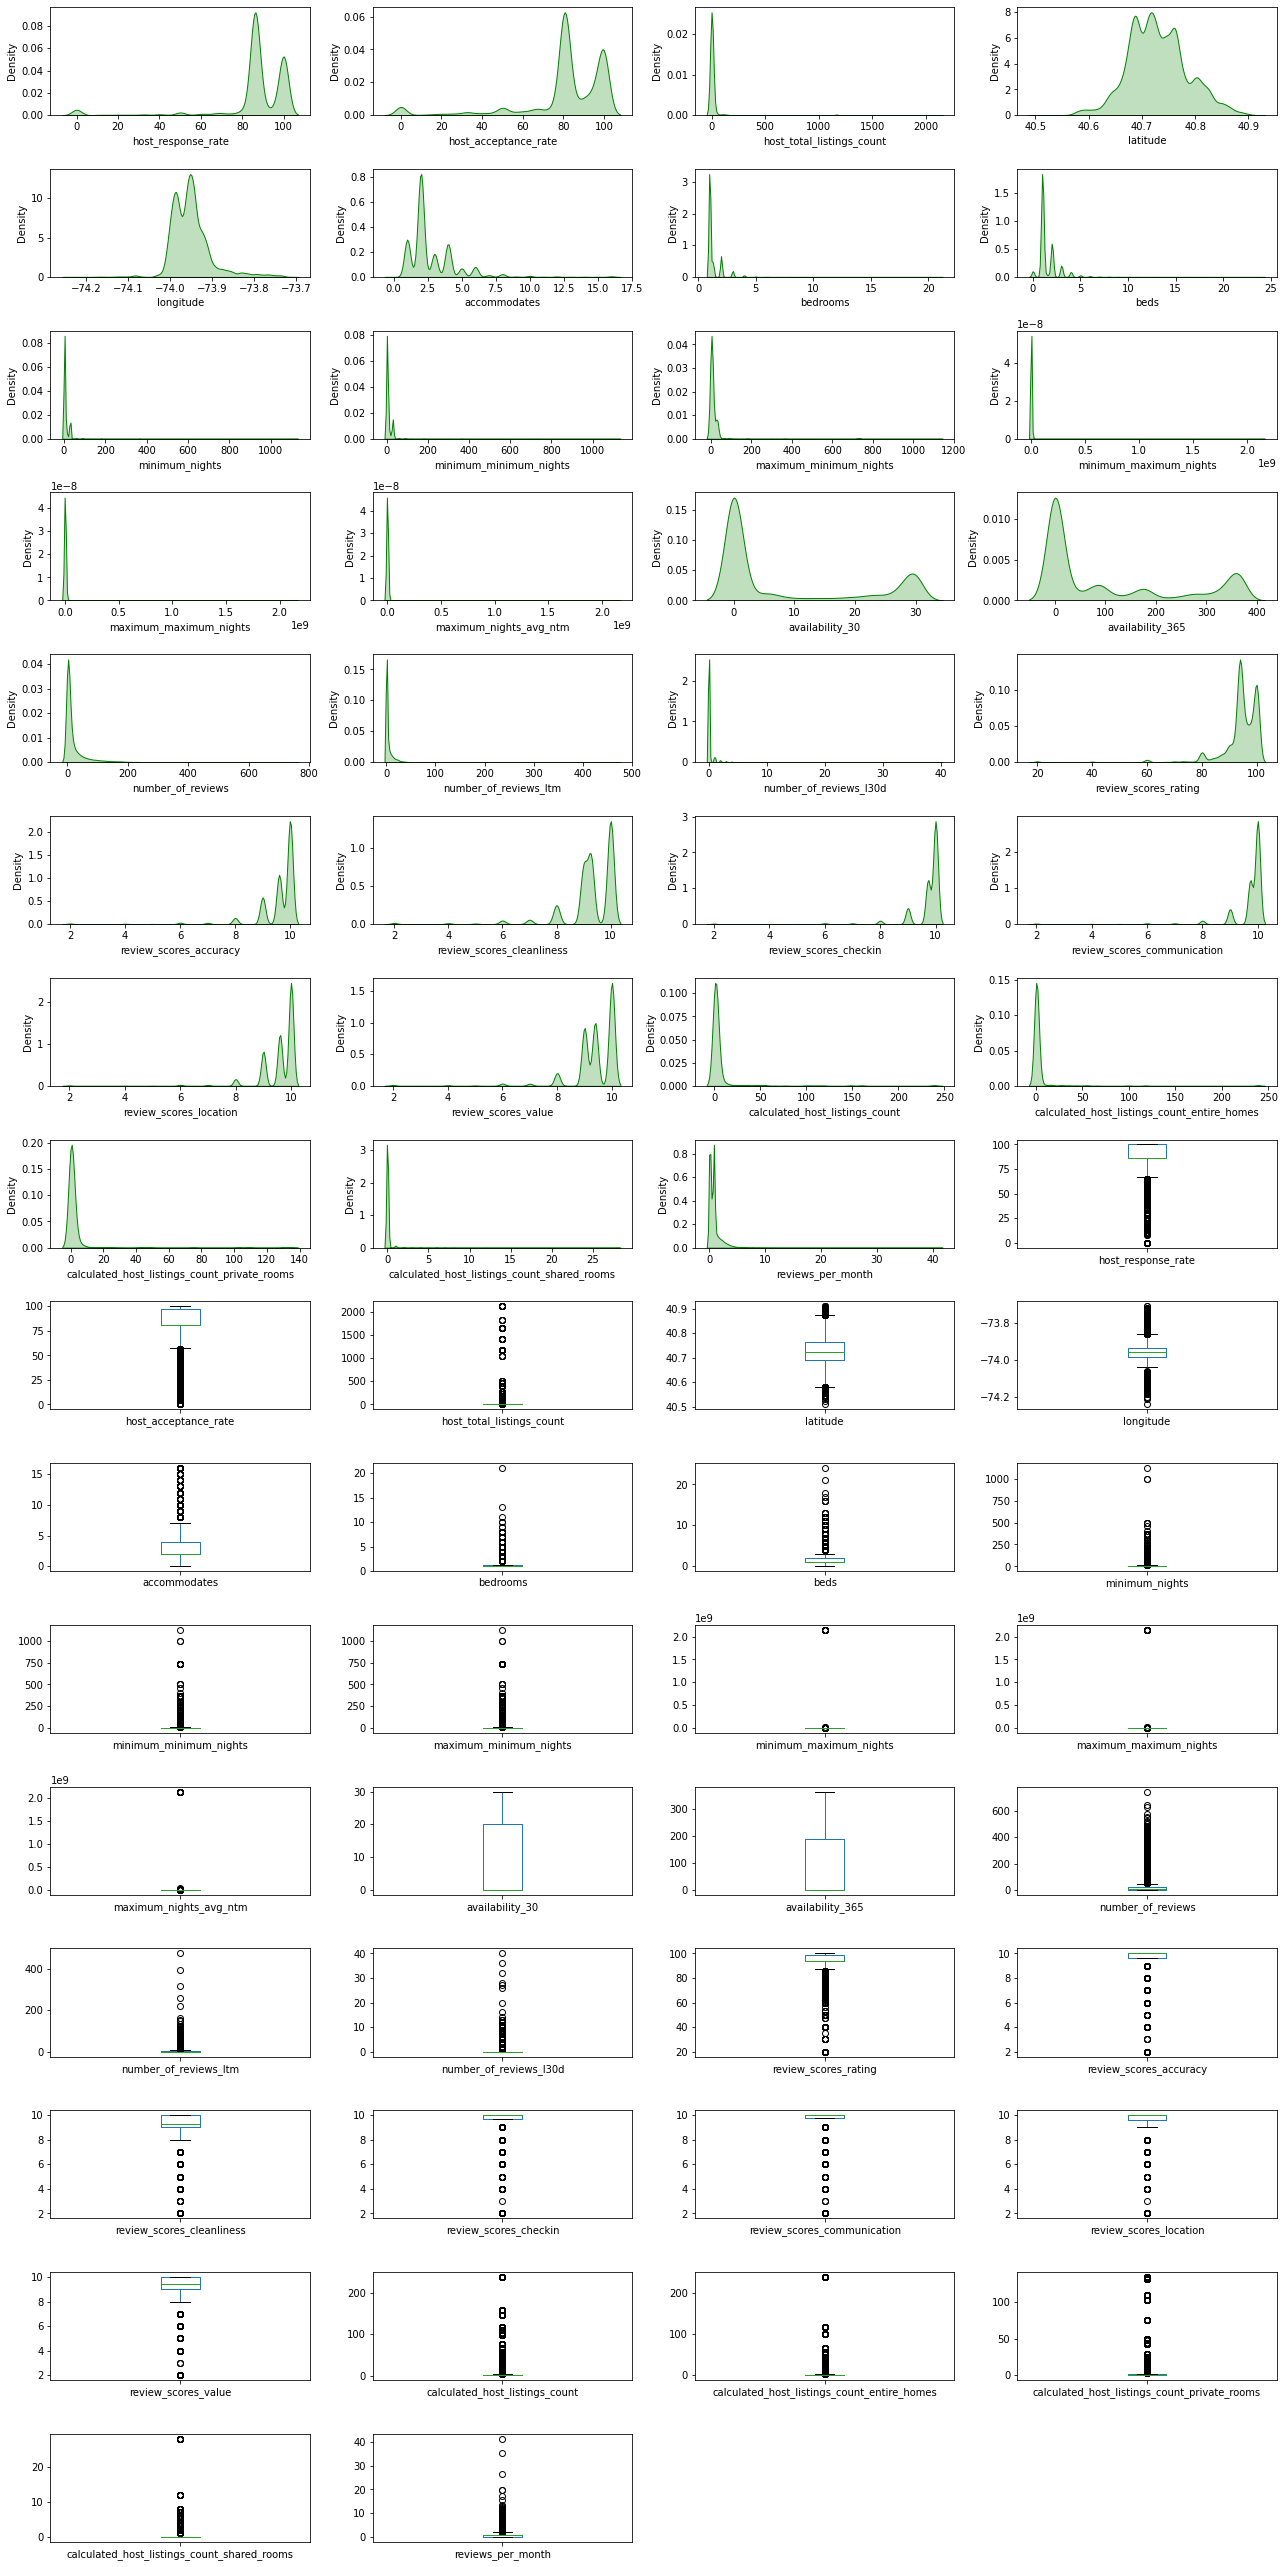

,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,maximum_nights_avg_ntm,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
skewness,-3.212575,-2.123412,11.168945,0.225187,1.378141,2.577353,4.095804,3.473828,14.920431,16.659393,11.223372,43.332269,31.457864,31.904781,1.007455,0.918440,3.974457,9.472685,12.808857,-4.405495,-4.901898,-3.221995,-6.202468,-6.283098,-4.478375,-3.726654,6.658438,9.746966,7.989467,22.579991,5.661101
kurtosis,11.332623,4.882888,134.430504,0.106051,4.558171,11.122734,42.001198,26.598992,414.982213,397.231771,135.145219,1875.807531,987.657322,1015.993136,-0.818817,-0.825404,22.384706,262.279083,344.901927,29.664282,35.196583,16.294449,53.880390,53.921933,35.162785,23.173816,49.812464,105.262282,66.095969,637.932583,103.481934


In [ ]:
# Visual exploration of numerical colums from simple imputer imputation
plt.figure(figsize= (18,40))

for i,col in enumerate(imputed_X.columns,1):
    plt.subplot(18,4,i)
    sns.kdeplot(imputed_X[col],color='g',shade=True)
    plt.subplot(18,4, i+len(imputed_X.columns))
    imputed_X[col].plot.box()
plt.tight_layout() 
plt.show()


num_data = imputed_X
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

In [ ]:
# Addressing missing values with KNN Imputer class
from sklearn.impute import KNNImputer

# Imputation
my_KNNimputer = KNNImputer(n_neighbors=4)
KNNimputed_X = pd.DataFrame(my_KNNimputer.fit_transform(X))
KNNimputed_Xtest = pd.DataFrame(my_KNNimputer.fit_transform(Xtest))

# Imputation removed column names; put them back
KNNimputed_X.columns = X.columns

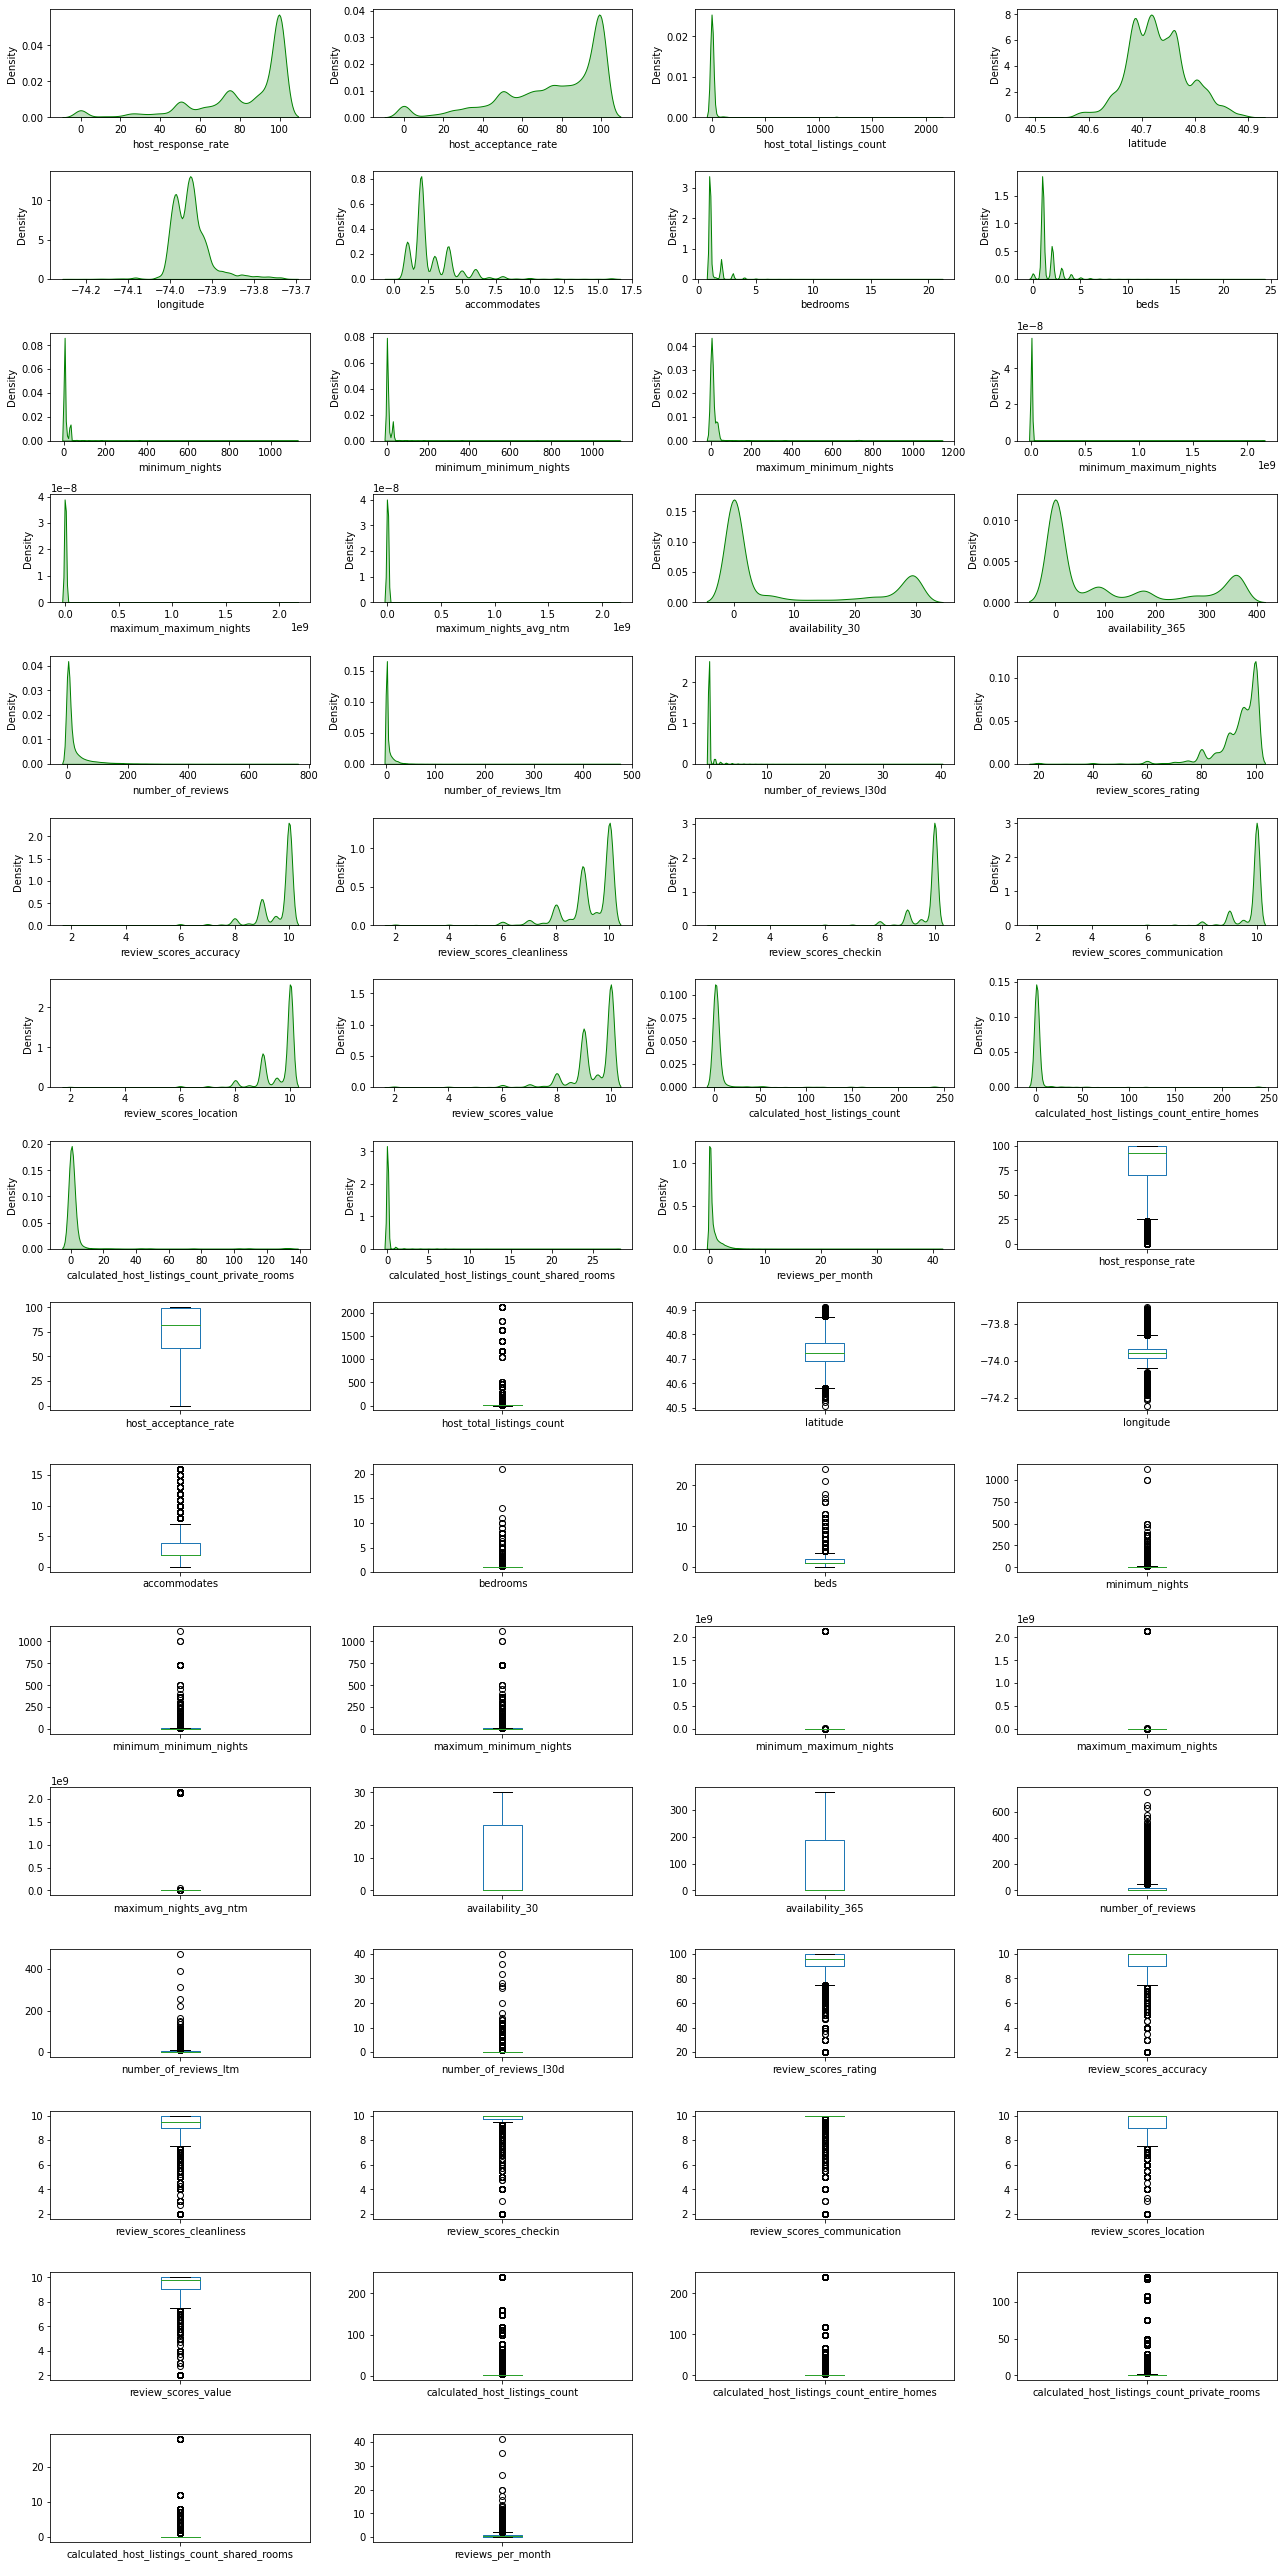

,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,maximum_nights_avg_ntm,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
skewness,-1.521644,-1.088135,11.168990,0.225187,1.378141,2.577353,4.008209,3.469189,14.920431,16.659221,11.223355,38.547179,29.471187,29.838026,1.007455,0.918440,3.974457,9.472685,12.808857,-3.256843,-3.636917,-2.431099,-4.605844,-4.651731,-3.502344,-2.817822,6.658438,9.746966,7.989467,22.579991,5.389515
kurtosis,1.854506,0.516892,134.431033,0.106051,4.558171,11.122734,40.144263,26.483576,414.982213,397.225177,135.144824,1483.978654,866.603019,888.373774,-0.818817,-0.825404,22.384706,262.279083,344.901927,16.939629,20.150075,9.352342,31.271766,31.326860,22.070171,13.484049,49.812464,105.262282,66.095969,637.932583,90.617791


In [ ]:
# Visual exploration of numerical colums generated from KNN imputation method
plt.figure(figsize= (18,40))

for i,col in enumerate(KNNimputed_X.columns,1):
    plt.subplot(18,4,i)
    sns.kdeplot(KNNimputed_X[col],color='g',shade=True)
    plt.subplot(18,4, i+len(KNNimputed_X.columns))
    KNNimputed_X[col].plot.box()
plt.tight_layout() 
plt.show()


num_data = KNNimputed_X
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

### Step 3: Feature Selection using select kbest method(mutual-info- regression and f-regression) and Lasso regression method

In [ ]:
# Extract feature columns from dataframe for further feature selection using KNNimputed
feature_cols = KNNimputed_X.columns 

# implement the scikit learn feature selction with the select K best library
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

In [ ]:
# Keep best 10 features using mutual_info_regression
selector_minfo = SelectKBest(mutual_info_regression, 10)

Xnew_minfo = selector_minfo.fit_transform(KNNimputed_X[feature_cols], num_df_train['price'])

#Xnew_minfo = selector_minfo.fit_transform(imputed_X[feature_cols], num_df_train['price'])

Xnew_minfo

array([[  1.     ,  40.85502, -73.92763, ...,   1.     ,   1.     ,
          0.     ],
       [  1.     ,  40.71172, -73.93973, ...,   1.     ,   0.     ,
          1.     ],
       [  2.     ,  40.8787 , -73.90098, ...,   2.     ,   0.     ,
          2.     ],
       ...,
       [ 50.     ,  40.6593 , -73.93512, ...,  43.     ,   0.     ,
         43.     ],
       [  0.     ,  40.67909, -73.99593, ...,   1.     ,   0.     ,
          1.     ],
       [  1.     ,  40.77648, -73.96126, ...,   1.     ,   1.     ,
          0.     ]])

In [ ]:
#Get back the features we've kept, zero out all other features
selected_features_minfo = pd.DataFrame(selector_minfo.inverse_transform(Xnew_minfo),
                                 index=num_df_train.index,
                                 columns= feature_cols)
selected_features_minfo.head()

,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,maximum_nights_avg_ntm,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0.0,0.0,1.0,40.85502,-73.92763,2.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,40.71172,-73.93973,2.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,2.0,40.87870,-73.90098,1.0,1.0,1.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
3,0.0,0.0,2.0,40.71731,-73.99108,6.0,3.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0
4,0.0,0.0,1.0,40.72392,-73.98915,2.0,1.0,1.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
# Dropped columns have values of all 0s, so var is 0, drop them
selected_columns_minfo = selected_features_minfo.columns[selected_features_minfo.var() != 0]
selected_columns_minfo

Index(['host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bedrooms', 'beds', 'maximum_minimum_nights',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms'],
      dtype='object')

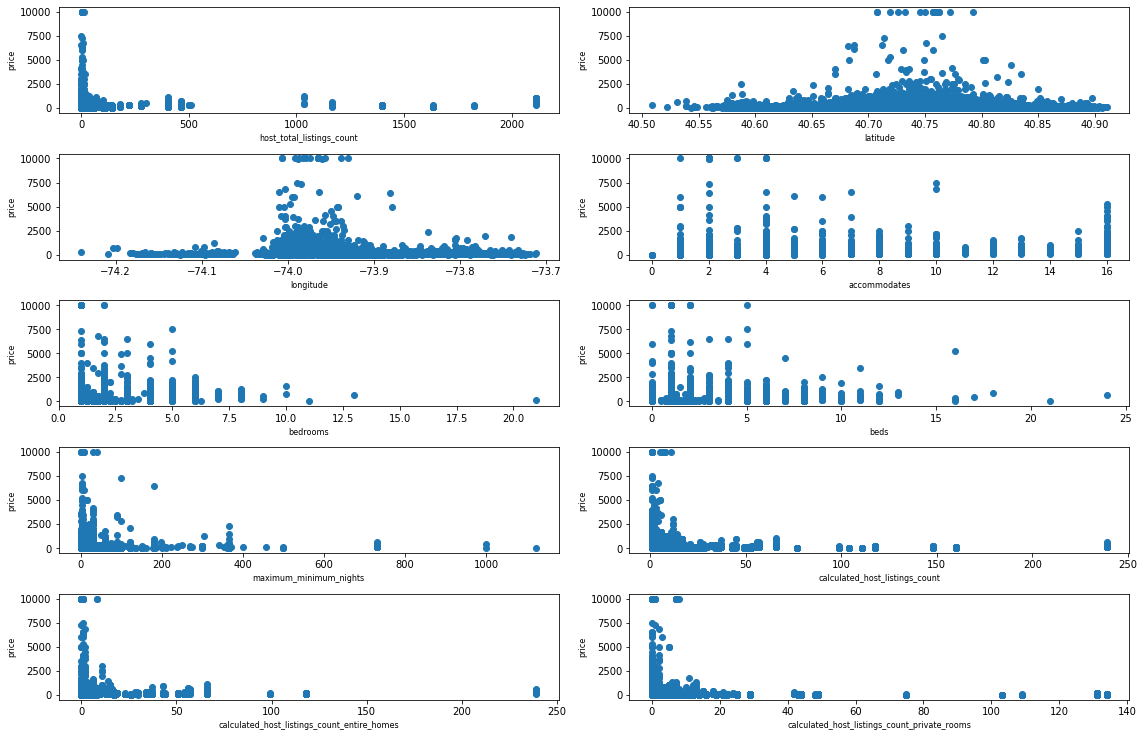

In [ ]:
# Visualize relationship between each numerical varaible and price
y = num_df_train['price']
X_minfo = KNNimputed_X[selected_columns_minfo]


plt.figure(figsize=(16,14), facecolor='white')
plotnumber = 1

for column in X_minfo:
    if plotnumber<=40 :
        ax = plt.subplot(7,2,plotnumber)
        plt.scatter(X_minfo[column],y)
        plt.xlabel(column,fontsize=8)
        plt.ylabel('price',fontsize=8)
    plotnumber+=1
plt.tight_layout()

In [ ]:
# Keep best 10 features using mutual_info_regression
selector_freg = SelectKBest(f_regression, 10)

Xnew_freg = selector_freg.fit_transform(KNNimputed_X[feature_cols], num_df_train['price'])

# Xnew_freg = selector_freg.fit_transform(imputed_X[feature_cols], num_df_train['price'])

Xnew_freg

array([[-73.92763,   2.     ,   1.     , ...,  19.     ,   9.     ,
          0.     ],
       [-73.93973,   2.     ,   1.     , ...,   0.     ,   9.5    ,
          1.     ],
       [-73.90098,   1.     ,   1.     , ...,  28.     ,   9.     ,
          2.     ],
       ...,
       [-73.93512,   2.     ,   1.     , ...,   0.     ,  10.     ,
         43.     ],
       [-73.99593,   1.     ,   1.     , ...,  30.     ,   9.     ,
          1.     ],
       [-73.96126,   2.     ,   1.     , ...,  28.     ,  10.     ,
          0.     ]])

In [ ]:
#Get back the features we've kept, zero out all other features
selected_features_freg = pd.DataFrame(selector_freg.inverse_transform(Xnew_freg),
                                 index=num_df_train.index,
                                 columns= feature_cols)
selected_features_freg.head()

,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,maximum_nights_avg_ntm,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0.0,0.0,0.0,0.0,-73.92763,2.0,1.0,1.0,0.0,0.0,0.0,1125.0,1125.0,1125.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,-73.93973,2.0,1.0,1.0,0.0,0.0,0.0,1125.0,1125.0,1125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.5,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,-73.90098,1.0,1.0,1.0,0.0,0.0,0.0,120.0,120.0,120.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,-73.99108,6.0,3.0,3.0,0.0,0.0,0.0,1125.0,1125.0,1125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,-73.98915,2.0,1.0,1.0,0.0,0.0,0.0,1125.0,1125.0,1125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Dropped columns have values of all 0s, so var is 0, drop them
selected_columns_freg = selected_features_freg.columns[selected_features_freg.var() != 0]
selected_columns_freg

Index(['longitude', 'accommodates', 'bedrooms', 'beds',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'maximum_nights_avg_ntm', 'availability_30', 'review_scores_value',
       'calculated_host_listings_count_private_rooms'],
      dtype='object')

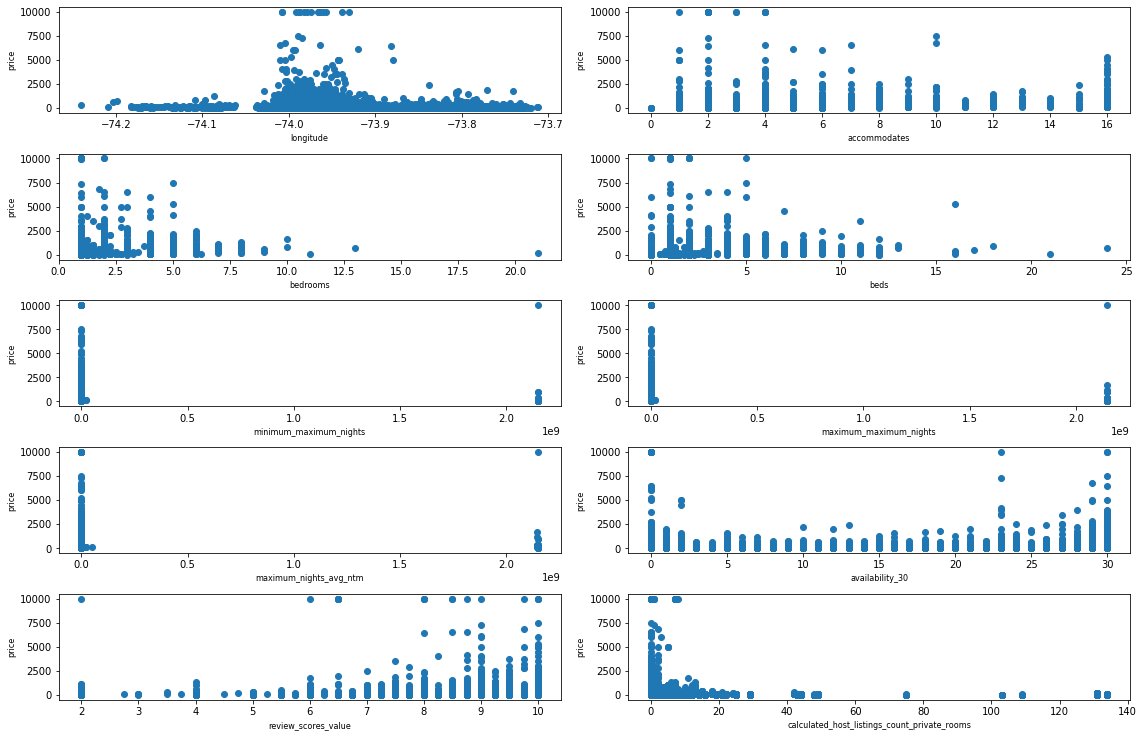

In [ ]:
# Visualize relationship between each numerical varaible and price
y = num_df_train['price']
X_freg = KNNimputed_X[selected_columns_freg]


plt.figure(figsize=(16,14), facecolor='white')
plotnumber = 1

for column in X_freg:
    if plotnumber<=40 :
        ax = plt.subplot(7,2,plotnumber)
        plt.scatter(X_freg[column],y)
        plt.xlabel(column,fontsize=8)
        plt.ylabel('price',fontsize=8)
    plotnumber+=1
plt.tight_layout()

In [ ]:
# Feature selection using L1 regression method
from sklearn.linear_model import Lasso                 # for regression problem
from sklearn.feature_selection import SelectFromModel

X_bl, y_bl = KNNimputed_X, num_df_train['price']



In [ ]:
# Set the regularization parameter alpha=1
lasso =  Lasso(alpha = 0.1, normalize = True).fit(X_bl, y_bl)

model = SelectFromModel(lasso, prefit=True)

X_bl_L1 = model.transform(X_bl)
X_bl_L1

# Get back the kept features as a DataFrame with dropped columns as all 0s
selected_features_L1 = pd.DataFrame(model.inverse_transform(X_bl_L1),
                                    index=X_bl.index,
                                    columns=feature_cols)

# Dropped columns have values of all 0s, so var is 0, drop them
selected_columns_L1 = selected_features_L1.columns[selected_features_L1.var() != 0]
selected_columns_L1

Index(['longitude', 'accommodates', 'bedrooms'], dtype='object')

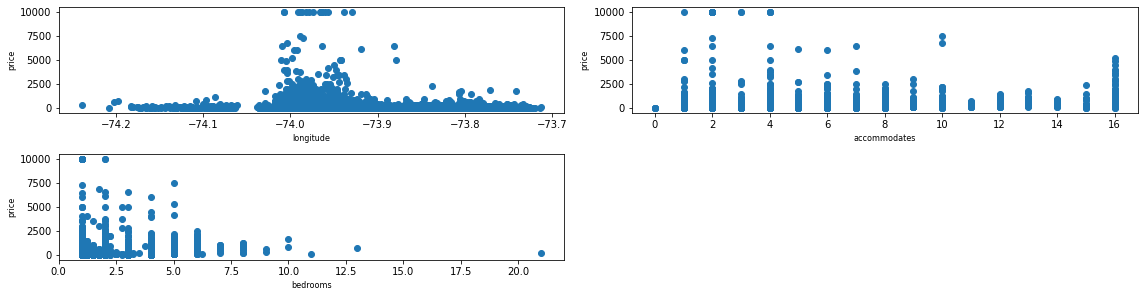

In [ ]:
# Visualize relationship between each numerical varaible and price
y = num_df_train['price']
X_L1 = KNNimputed_X[selected_columns_L1]


plt.figure(figsize=(16,14), facecolor='white')
plotnumber = 1

for column in X_L1:
    if plotnumber<=40 :
        ax = plt.subplot(7,2,plotnumber)
        plt.scatter(X_L1[column],y)
        plt.xlabel(column,fontsize=8)
        plt.ylabel('price',fontsize=8)
    plotnumber+=1
plt.tight_layout()

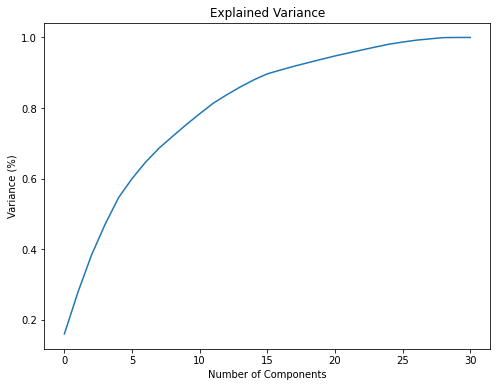

In [ ]:
# fEATURE SELCTION using PCA
# Standardize knn dataframe
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()

X_sc = sc.fit_transform(KNNimputed_X)

from sklearn.decomposition import PCA
pca1 = PCA()
principalComponents = pca1.fit_transform(X_sc)

plt.figure(figsize= (8,6))
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

The plot shows that 18 principal components describe about 90% on the variation in data

In [ ]:
# Perform PCA with optimum settings:whuch is 18 components
pca_knn = PCA(n_components=18)
num_dataset = pca_knn.fit_transform(X_sc)

num_df_pca = pd.DataFrame(num_dataset,columns=['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8',
                                             'PC-9','PC-10','PC-11','PC-12','PC-13','PC-14','PC-15',
                                             'PC-16','PC-17','PC-18'])
num_df_pca.head(2)

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,PC-11,PC-12,PC-13,PC-14,PC-15,PC-16,PC-17,PC-18
0,-0.234055,-0.121907,0.859278,0.062967,-1.043175,1.145116,-1.323719,-0.018895,-1.467439,0.515998,-0.376600,1.362300,0.983776,-0.567755,1.261661,0.158595,-0.587822,-0.392898
1,-0.951706,-0.104652,-1.426813,-0.050597,-0.389202,-0.553517,0.235721,0.366723,0.021709,0.247703,-0.101936,-0.595874,0.339525,-0.359898,0.013350,0.254649,0.007066,0.040943


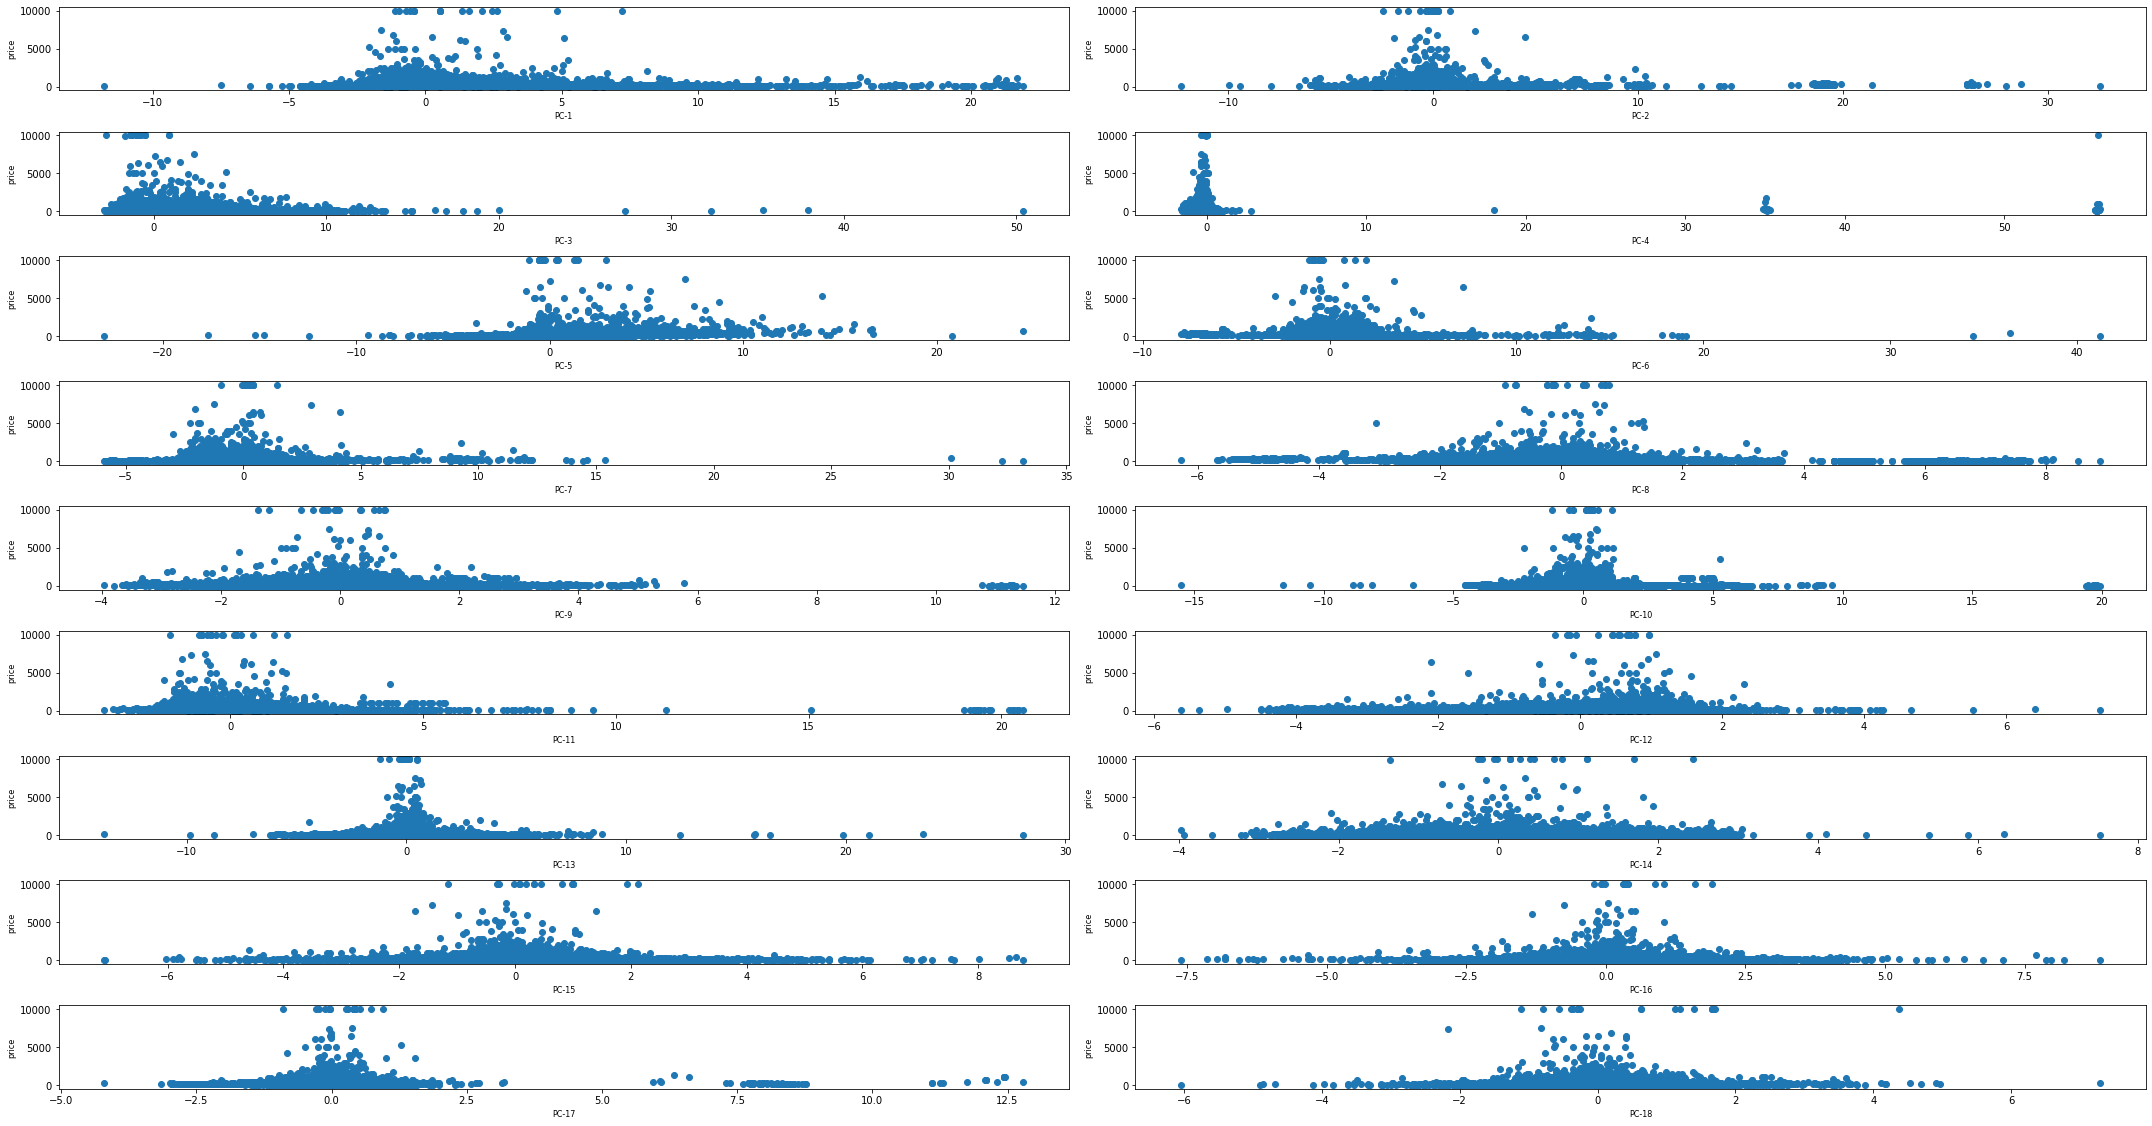

In [ ]:
# Visualize relationship between each numerical varaible and price
y = num_df_train['price']
X_pca = num_df_pca


plt.figure(figsize=(30,24), facecolor='white')
plotnumber = 1

for column in X_pca:
    if plotnumber<=40 :
        ax = plt.subplot(14,2,plotnumber)
        plt.scatter(X_pca[column],y)
        plt.xlabel(column,fontsize=8)
        plt.ylabel('price',fontsize=8)
    plotnumber+=1
plt.tight_layout()

### Step 3: Model Development & Fitting

In [ ]:
# Define X_best using the feature selection output
X_best = X_minfo.copy()
X_best.head(2)

,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,maximum_minimum_nights,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms
0,1.0,40.85502,-73.92763,2.0,1.0,1.0,6.0,1.0,1.0,0.0
1,1.0,40.71172,-73.93973,2.0,1.0,1.0,2.0,1.0,0.0,1.0


In [ ]:
# Check for multicolineraity 
#Import regression models from sklearn
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Let's move ahead and check for multicollinearity.
scaler =StandardScaler()

X_scaled = scaler.fit_transform(X_best) # set the X feature selected

from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_scaled

# we create a new data frame which will include all the VIFs
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = X_minfo.columns

vif

,VIF,Features
0,2.228278,host_total_listings_count
1,1.016904,latitude
2,1.025518,longitude
3,2.591567,accommodates
4,2.370997,bedrooms
5,2.540653,beds
6,3.138768,maximum_minimum_nights
7,250.676482,calculated_host_listings_count
8,165.882832,calculated_host_listings_count_entire_homes
9,78.972479,calculated_host_listings_count_private_rooms


In [ ]:
# We drop all columns with VIF greater than 5 due to colineraity 
to_drop_cols = vif[vif['VIF']> 5].Features.tolist()
# Drop columns
X_best.drop(to_drop_cols, axis= 1, inplace=True)


In [ ]:
# Print X: feature columns
X_best[0:2]

,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,maximum_minimum_nights
0,1.0,40.85502,-73.92763,2.0,1.0,1.0,6.0
1,1.0,40.71172,-73.93973,2.0,1.0,1.0,2.0


In [ ]:
# Print y: target variable and convert to array
y= y.values
y = y.reshape(len(y),1)
y

array([[110.],
       [ 60.],
       [ 39.],
       ...,
       [ 44.],
       [250.],
       [225.]])

In [ ]:
# Convert dataframe into array
X = X_best.copy()
X = X.iloc[:, 1:-1].values
X[0:2]

array([[ 40.85502, -73.92763,   2.     ,   1.     ,   1.     ],
       [ 40.71172, -73.93973,   2.     ,   1.     ,   1.     ]])

In [ ]:
# Split data into train test split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2)

In [ ]:
# Let's create a function to create adjusted R-Squared
def adj_r2(x,y):
    r2 = regression.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adjusted_r2

In [ ]:
# Standardize dataframe
sc2 = StandardScaler()
sc3 = StandardScaler()

X_train_sc = sc2.fit_transform(X_train)
X_valid_sc = sc2.transform(X_valid)

y_train_sc = sc3.fit_transform(y_train)
y_valid_sc = sc3.transform(y_valid)

Xtrain_sc[0:2]

array([[-0.11745318,  0.5906067 , -0.72407308, -0.42039303, -0.43492631,
        -0.23977313, -0.14436483],
       [-0.00897982,  0.29853723,  1.21362514, -0.96826676, -0.43492631,
        -0.46790198,  0.28126462]])

#### Model 1: Regression Models

In [ ]:
# Fit linear regression model
regression = LinearRegression()

regression.fit(X_train_sc,y_train_sc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Performance of model on train set
print(regression.score(X_train_sc,y_train_sc))
print(adj_r2(X_train_sc,y_train_sc))

0.07605074876307884
0.07588909482451833


In [ ]:
# Performance of model on validation set
print(regression.score(X_valid_sc,y_valid_sc))
print(adj_r2(X_valid_sc,y_valid_sc))

0.09524374473491926
0.09461025064777095


#### Model 2: Lasso CV Regression Model

In [ ]:
# Lasso Regularization
# LassoCV will return best alpha and coefficients after performing 10 cross validations
lasscv = LassoCV(alphas = None,cv =5, max_iter = 100000, normalize = True)
lasscv.fit(X_train_sc, y_train_sc)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=100000, n_alphas=100, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [ ]:
# best alpha parameter
alpha = lasscv.alpha_
alpha

1.4598444804256118e-06

In [ ]:
#now that we have best parameter, let's use Lasso regression and see how well our data has fitted before
lasso_reg = Lasso(alpha)
lasso_reg.fit(X_train_sc, y_train_sc)
lasso_reg.score(X_train_sc, y_train_sc)

0.07605074873771989

In [ ]:
# Evaluate model on validation set
lasso_reg.score(X_valid_sc, y_valid_sc)

0.09524338949721378

#### Model 3 : Polynomial Regression

In [ ]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 3)  
X_train_poly = poly_reg.fit_transform(X_train_sc)
X_valid_poly = poly_reg.transform(X_valid_sc)

poly_reg.fit(X_train_poly, y_train_sc)

PolynomialFeatures(degree=3, include_bias=True, interaction_only=False,
                   order='C')

In [ ]:
# doing the actual polynomial Regression
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train_sc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Performance of model on train set
print(poly_reg.score(X_train_poly,y_train_sc))

0.10982037003414069


In [ ]:
# Performance of model on validation set
print(poly_reg.score(X_valid_poly,y_valid_sc))


0.13703893123667443


#### Model 3: Decision Tree Regression Model

In [ ]:
# Create decison tree object and fit model
from sklearn.tree import  DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
# Fit and evaluate model
tree.fit(X_train, y_train)
print("The training set accurcay is : " , tree.score(X_train,y_train))
print("The test set accurcay is : " , tree.score(X_valid,y_valid))

The training set accurcay is :  0.9989663292387461
The test set accurcay is :  -1.2428202419273413


#### Model 4: Support Vector Regression Model

In [ ]:
# Training the SVR model on the whole dataset
from sklearn.svm import SVR
rbf = SVR(kernel = 'rbf')
rbf.fit(X_train_sc, y_train_sc)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
# Fit and evaluate model
print("The training set accurcay is : " , rbf.score(X_train_sc,y_train_sc))
print("The test set accurcay is : " , rbf.score(X_valid_sc,y_valid_sc))

The training set accurcay is :  0.10223833488161327
The test set accurcay is :  0.12046747706412687


#### Model 5: XGBoost Regression Model

In [ ]:
# Build xgb model and fit
import xgboost
from xgboost import  XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train_sc, y_train_sc)

[20:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# Fit and evaluate model
print("The training set accurcay is : " , xgb.score(X_train_sc,y_train_sc))
print("The test set accurcay is : " , xgb.score(X_valid_sc,y_valid_sc))

The training set accurcay is :  0.23246967980659528
The test set accurcay is :  0.12251599544933922


#### Model 6:  Gradient Boosting model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(X_train_sc, y_train_sc)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# Fit and evaluate model
print("The training set accurcay is : " , gb.score(X_train_sc,y_train_sc))
print("The test set accurcay is : " , gb.score(X_valid_sc,y_valid_sc))

The training set accurcay is :  0.2737434968026212
The test set accurcay is :  0.1187639650665404


###### Hyperparameter tuning of Gradient Classifier Model

In [ ]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
from sklearn.model_selection import GridSearchCV
gb = GradientBoostingRegressor()
parameters = {
    'n_estimators': [50, 250, 500],
    'learning_rate': [0.01, 0.1, 1]
}

cv = GridSearchCV(gb, parameters, cv=5)
cv.fit(X_train_sc, y_train_sc)

print_results(cv)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

KeyboardInterrupt: ignored

#### Model 6: CatBoost Regression Model

In [ ]:
# Create model and fit
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
cat.fit(X_train_sc, y_train_sc)


Learning rate set to 0.070891
0:	learn: 0.9936868	total: 58.1ms	remaining: 58.1s
1:	learn: 0.9880830	total: 63.8ms	remaining: 31.9s
2:	learn: 0.9835843	total: 69.3ms	remaining: 23s
3:	learn: 0.9790596	total: 74.4ms	remaining: 18.5s
4:	learn: 0.9750799	total: 79.8ms	remaining: 15.9s
5:	learn: 0.9713346	total: 84.9ms	remaining: 14.1s
6:	learn: 0.9678861	total: 90.1ms	remaining: 12.8s
7:	learn: 0.9649804	total: 95.7ms	remaining: 11.9s
8:	learn: 0.9621806	total: 101ms	remaining: 11.1s
9:	learn: 0.9595066	total: 116ms	remaining: 11.5s
10:	learn: 0.9576789	total: 124ms	remaining: 11.2s
11:	learn: 0.9554715	total: 129ms	remaining: 10.6s
12:	learn: 0.9535214	total: 134ms	remaining: 10.2s
13:	learn: 0.9519188	total: 144ms	remaining: 10.2s
14:	learn: 0.9504643	total: 150ms	remaining: 9.83s
15:	learn: 0.9484239	total: 155ms	remaining: 9.52s
16:	learn: 0.9470175	total: 160ms	remaining: 9.27s
17:	learn: 0.9456729	total: 165ms	remaining: 9.02s
18:	learn: 0.9444579	total: 170ms	remaining: 8.8s
19:	le

In [ ]:
# Fit and evaluate model
print("The training set accurcay is : " , cat.score(X_train_sc,y_train_sc))
print("The test set accurcay is : " , cat.score(X_valid_sc,y_valid_sc))

The training set accurcay is :  -37483.58832979571
The test set accurcay is :  -8843.751094668012
